In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

## Simulation

### Speed and Position

Simulate an animal running back and forth on a track with pauses at the top of the track

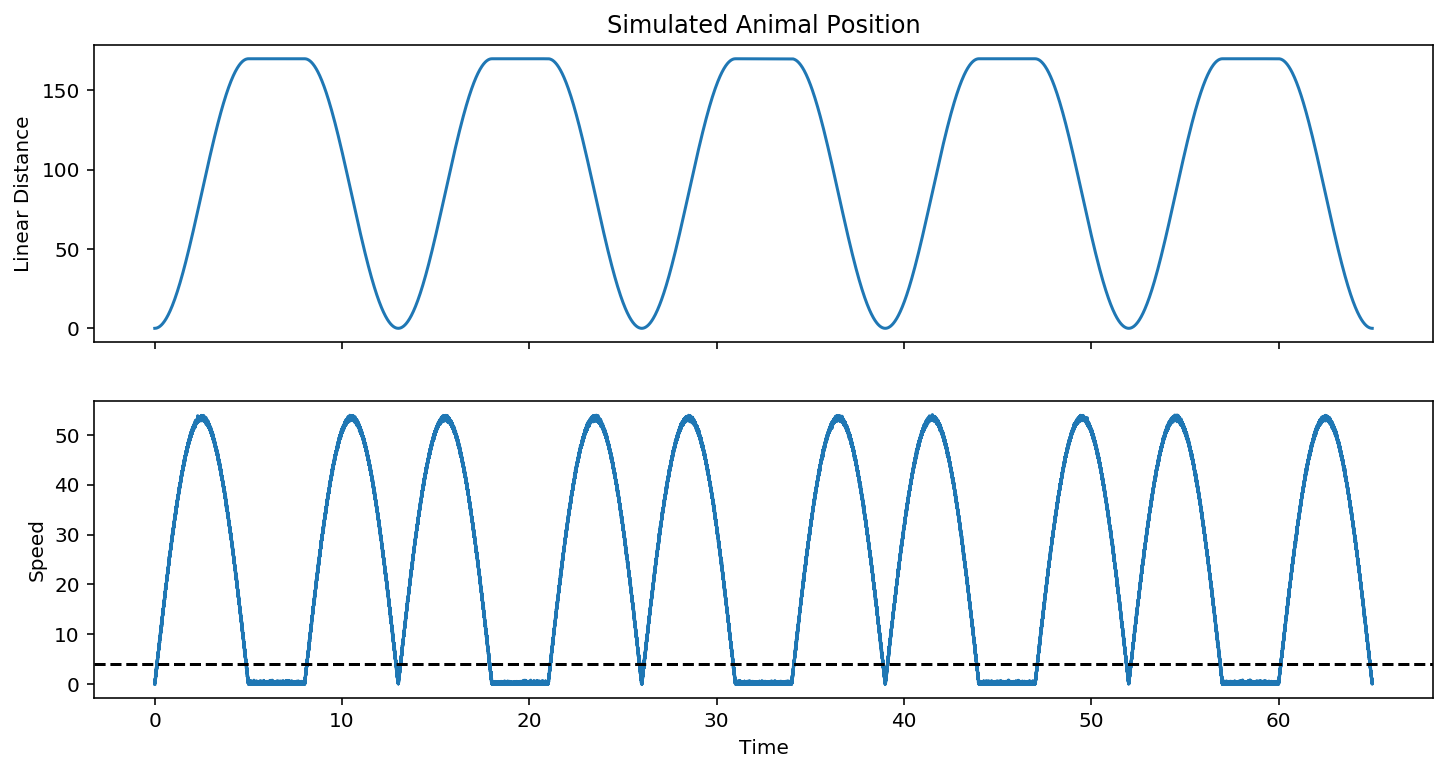

In [3]:
from replay_identification.simulate_spiking import simulate_time, simulate_linear_distance_with_pauses
from numpy.random import randn

track_height = 170
sampling_frequency = 1500
n_samples = sampling_frequency * 65

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time = simulate_time(n_samples, sampling_frequency)
linear_distance = simulate_linear_distance_with_pauses(
    time, track_height, sampling_frequency=sampling_frequency, pause=3) + randn(*time.shape) * 1E-4
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Simulated Animal Position')

speed = np.abs(np.diff(linear_distance) / np.diff(time))
speed = np.insert(speed, 0, 0.0)

axes[1].plot(time, speed)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed')
axes[1].axhline(4, linestyle='--', color='black');

### LFPs with ripples

The simulated animal pauses 5 times. Simulate 100 ms ripple band (200 Hz) events for the first 3 pauses.

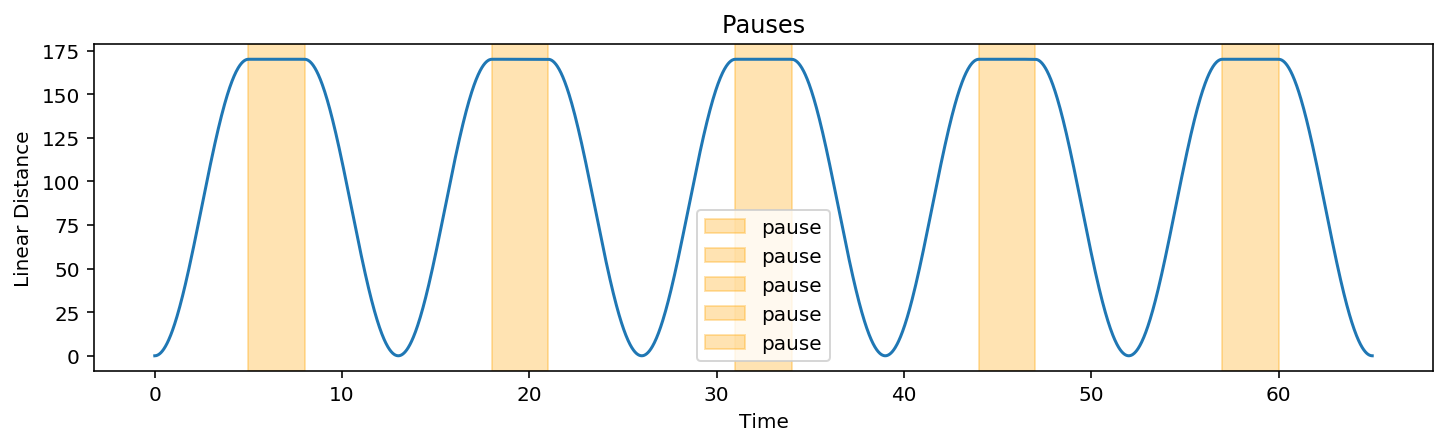

In [4]:
pause_ind = np.nonzero(np.diff(np.isclose(linear_distance, track_height, atol=1E-5)))[0] + 1

pause_times = time[np.reshape(pause_ind, (-1, 2))]
pause_width = np.diff(pause_times)[0]

fig, axes = plt.subplots(1, 1, figsize=(12, 3), sharex=True)
axes.plot(time, linear_distance);
axes.set_xlabel('Time')
axes.set_ylabel('Linear Distance')
axes.set_title('Pauses')

for start_time, end_time in pause_times:
    axes.axvspan(start_time, end_time, alpha=0.3, color='orange', label='pause')
    
plt.legend();

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


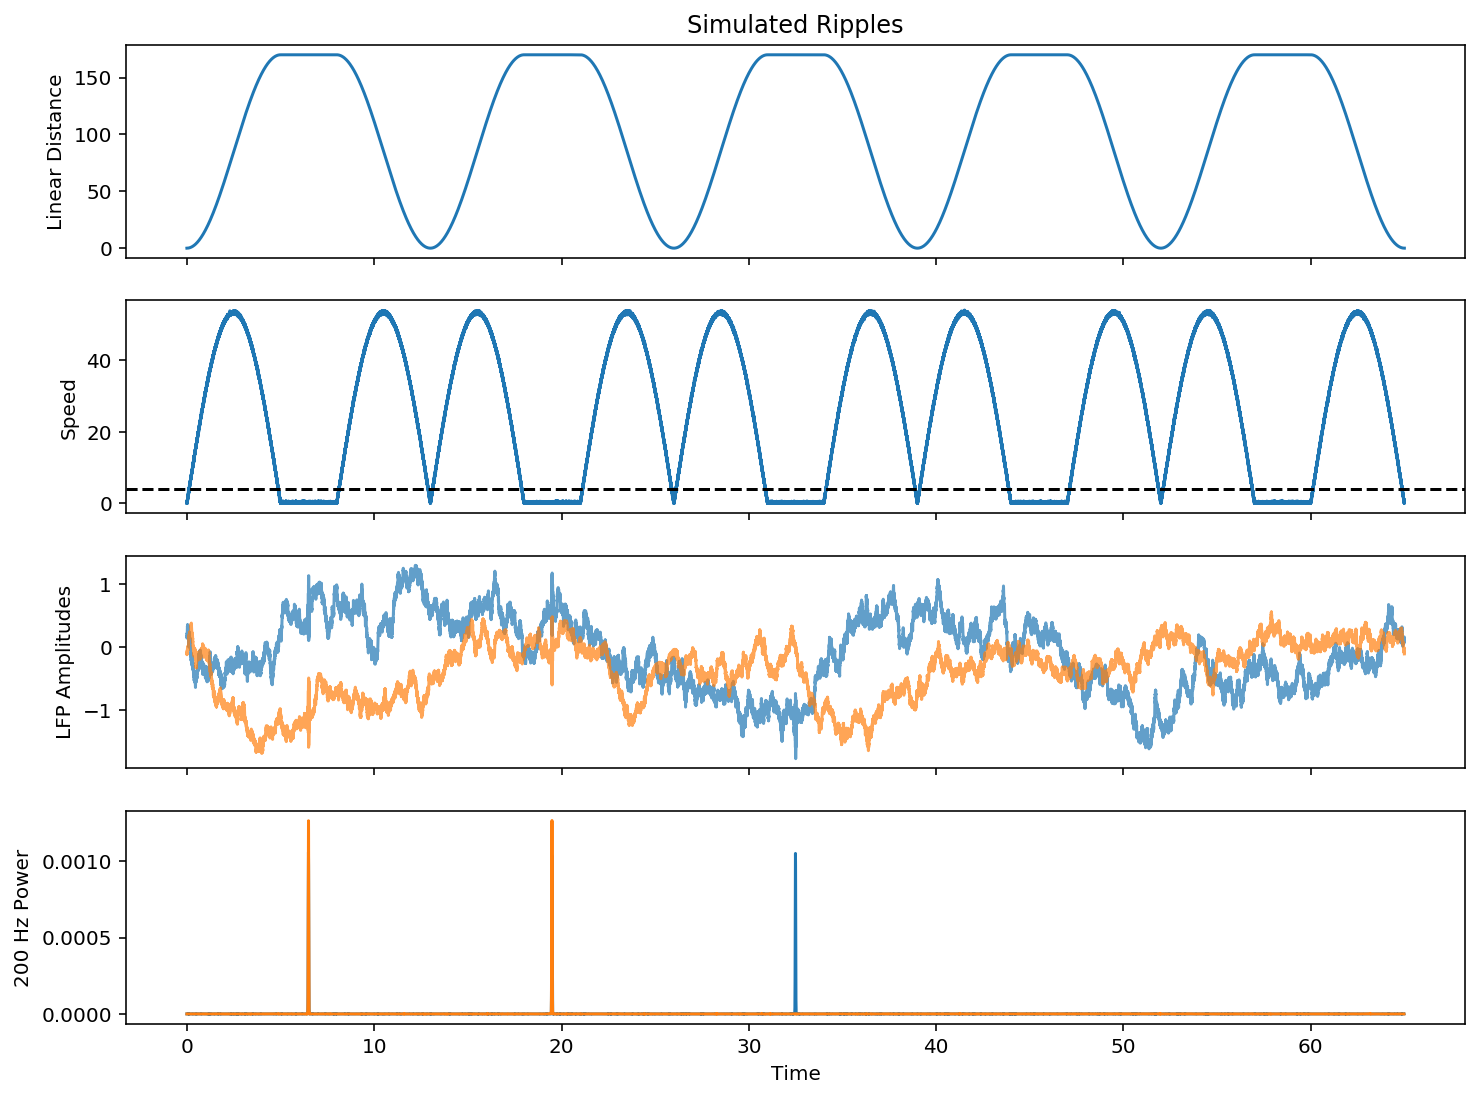

In [5]:
from replay_identification.simulate_LFP import simulate_LFP
from spectral_connectivity import Multitaper, Connectivity

ripple_duration = 0.100


lfps = np.stack((
    simulate_LFP(time, pause_times[:3, 0] + pause_width / 2, noise_amplitude=1.2,
                 ripple_amplitude=1, ripple_width=ripple_duration),
    simulate_LFP(time, pause_times[:2, 0] + pause_width / 2, noise_amplitude=1.2,
                 ripple_amplitude=1.1, ripple_width=ripple_duration)), axis=1
)


def estimate_ripple_band_power(lfps, sampling_frequency):
    """Estimates the 200 Hz power of each LFP.

    Parameters
    ----------
    lfps : ndarray, shape (n_time, n_signals)
    sampling_frequency : float

    Returns
    -------
    ripple_band_power : ndarray (n_time, n_signals)

    """
    n_time = lfps.shape[0]
    m = Multitaper(lfps, sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=1,
                   time_window_duration=0.020,
                   time_window_step=1 / sampling_frequency)
    c = Connectivity.from_multitaper(m)
    closest_200Hz_freq_ind = np.argmin(np.abs(c.frequencies - 200))
    power = c.power()[..., closest_200Hz_freq_ind, :].squeeze()
    n_power_time = power.shape[0]
    unobserved = np.full((n_time - n_power_time, *power.shape[1:]), np.nan)
    return np.concatenate((power, unobserved))

power = estimate_ripple_band_power(lfps, sampling_frequency)


fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Simulated Ripples')

axes[1].plot(time, speed)

axes[1].set_ylabel('Speed')
axes[1].axhline(4, linestyle='--', color='black');
axes[2].plot(time, lfps, alpha=0.7, )
axes[2].set_ylabel('LFP Amplitudes')
axes[3].plot(time, power);
axes[3].set_ylabel('200 Hz Power')
axes[-1].set_xlabel('Time');

In [6]:
mid_ripple_time = pause_times[:3, 0] + pause_width / 2
ripple_times = (mid_ripple_time + np.array([-0.5, 0.5])[:, np.newaxis] * ripple_duration).T

Close up on the first simulated ripple to verify it worked

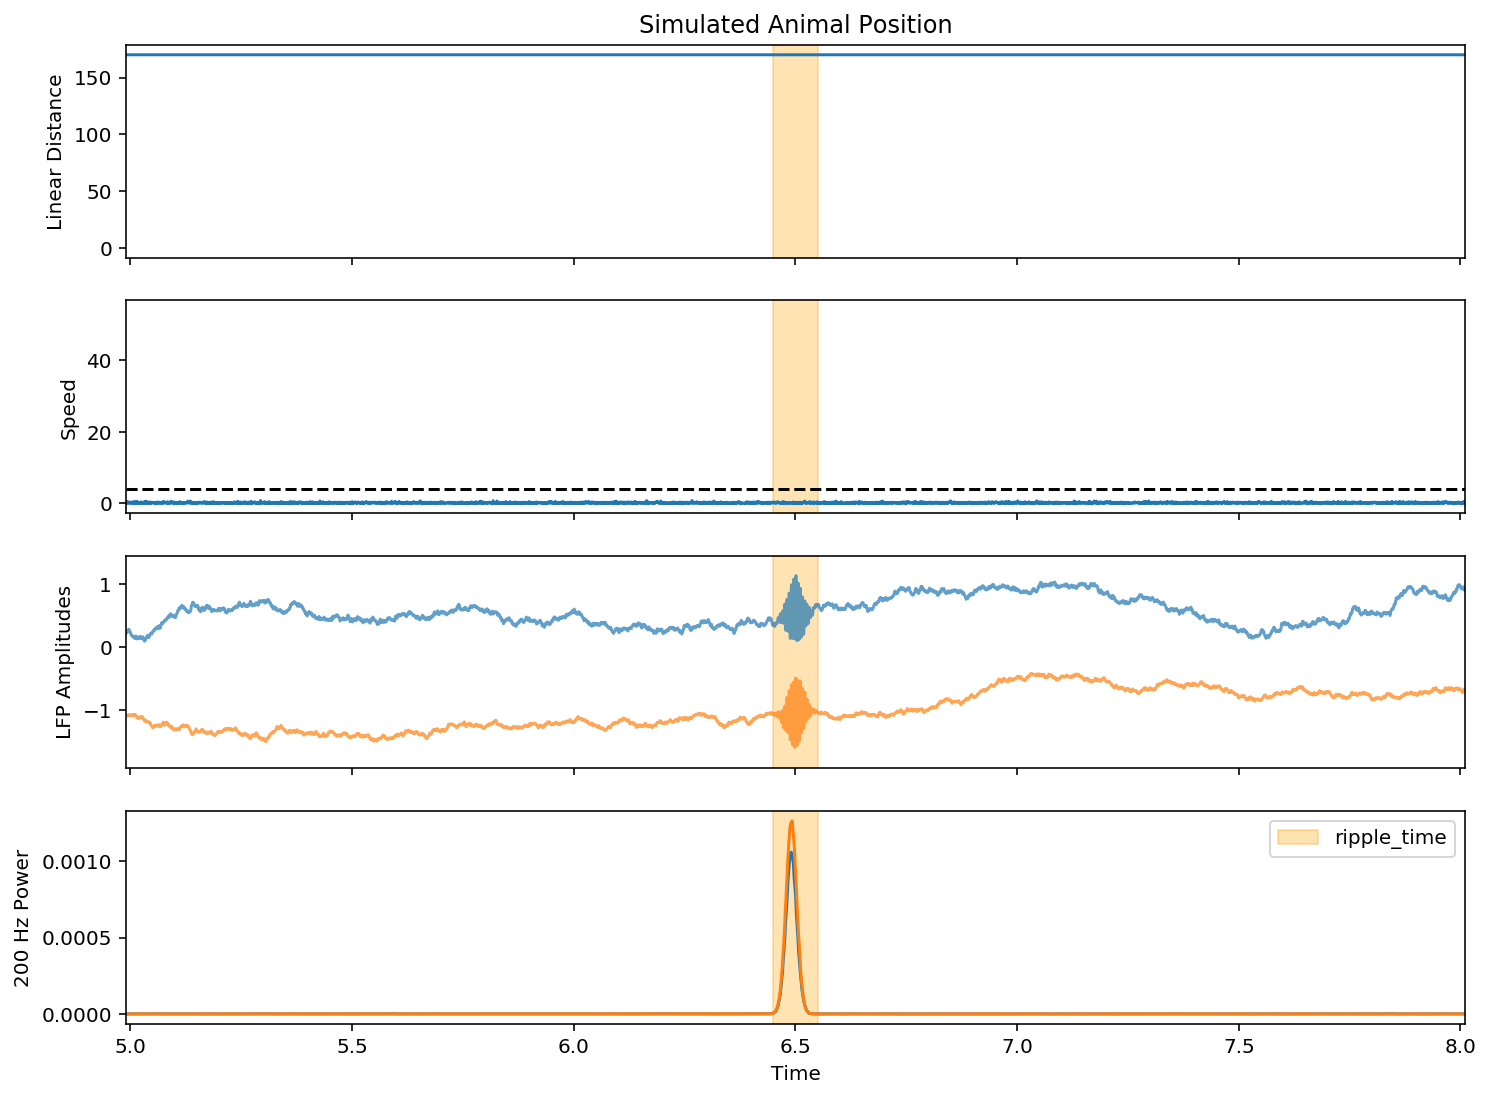

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Simulated Animal Position')
axes[0].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3)

axes[1].plot(time, speed)

axes[1].set_ylabel('Speed')
axes[1].axhline(4, linestyle='--', color='black')
axes[1].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3)
axes[2].plot(time, lfps, alpha=0.7, )
axes[2].set_ylabel('LFP Amplitudes')
axes[2].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3)
axes[3].plot(time, power);
axes[3].set_ylabel('200 Hz Power')
axes[3].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3, label='ripple_time')
axes[-1].set_xlabel('Time');

plt.xlim((pause_times[0]))
plt.legend();

### Spikes with Place Fields

Simulate spikes with replay events on the 1st and 4th pauses

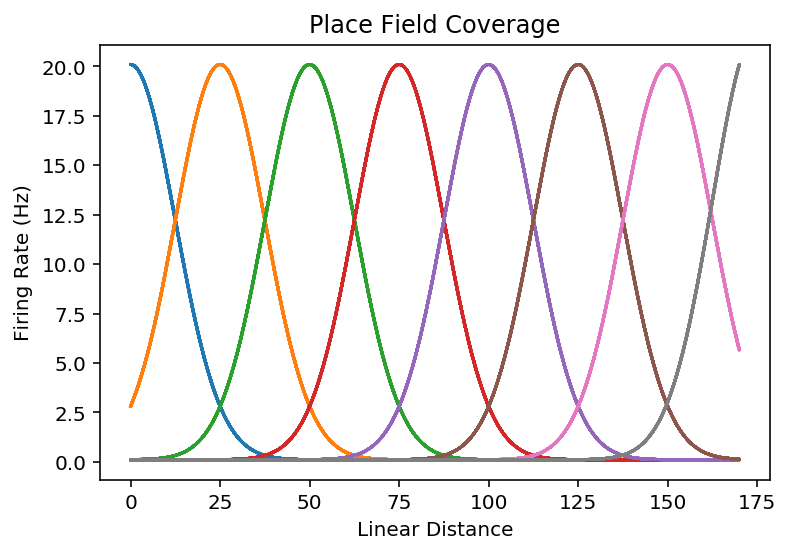

In [8]:
from replay_identification.simulate_spiking import create_place_field

place_field_support = np.arange(0, track_height)
place_field_means = np.arange(0, 200, 25)

place_fields = np.stack([create_place_field(
    place_field_mean, linear_distance, sampling_frequency)
                         for place_field_mean in place_field_means])
plt.plot(linear_distance, place_fields.T)
plt.xlabel('Linear Distance')
plt.ylabel('Firing Rate (Hz)')
plt.title('Place Field Coverage');

(97500, 8)


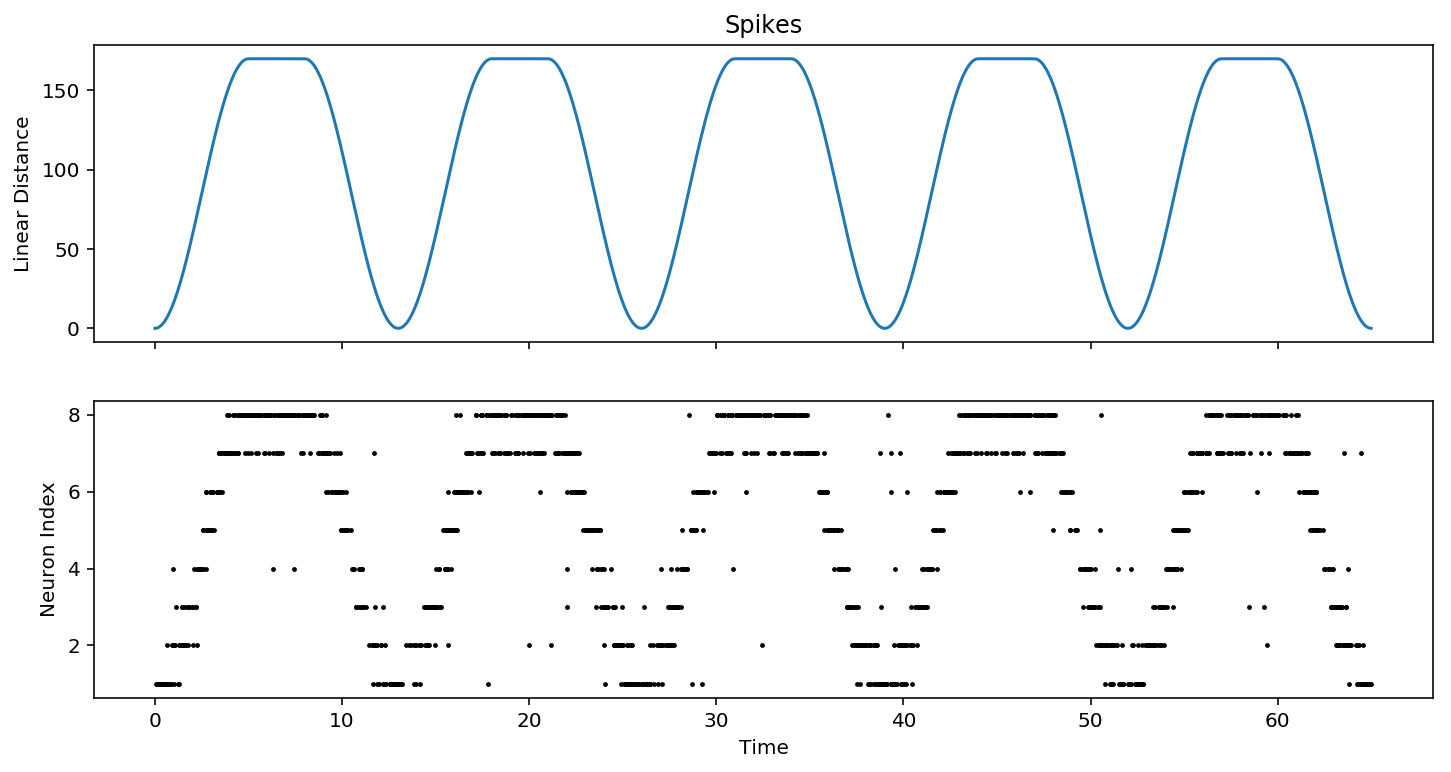

In [9]:
from replay_identification.simulate_spiking import simulate_poisson_spikes

spikes = simulate_poisson_spikes(place_fields, sampling_frequency).T
print(spikes.shape)

spike_ind, neuron_ind = np.nonzero(spikes)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(time, linear_distance)
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Spikes')
axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_ylabel('Neuron Index')
axes[-1].set_xlabel('Time');

#### Insert replay events in spiking for ripples \#1 and \#3

One in each direction (toward, away)

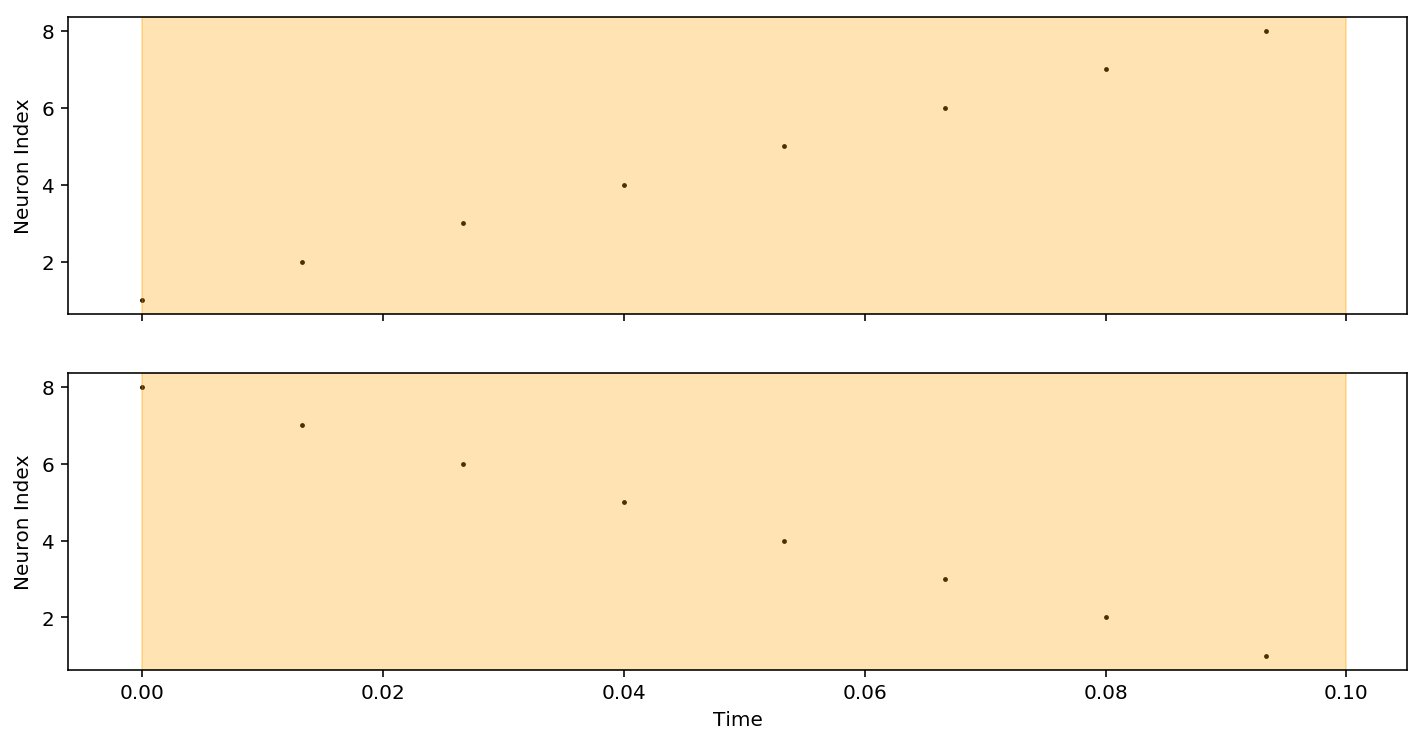

In [10]:
n_neurons = spikes.shape[1]
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
n_samples_between_spikes = 20
is_toward = np.array([0, 1], dtype=bool)

for ax, (start_time, end_time), flip in zip(axes, ripple_times[[0, -1]], is_toward):
    is_ripple_time = (time >= start_time) & (time <= end_time)
    ripple_ind = np.nonzero(is_ripple_time)[0]
    spikes[is_ripple_time] = 0
    neuron_order = np.flip(np.arange(n_neurons), axis=0) if flip else np.arange(n_neurons)
    replay_ind = (
        ripple_ind[0] +
        np.arange(0, n_neurons * n_samples_between_spikes, n_samples_between_spikes),
        neuron_order)
    spikes[replay_ind] = 1
    
    spike_ind, neuron_ind = np.nonzero(spikes[is_ripple_time])
    ax.scatter(spike_ind / sampling_frequency, neuron_ind + 1, color='black', s=2)
    ax.set_ylabel('Neuron Index')
    ax.axvspan(0, ripple_duration, alpha=0.3, color='orange')
    
axes[-1].set_xlabel('Time');

### Multiunit

In [11]:
from replay_identification.simulate_multiunit import simulate_multiunit

mark_means = np.array([200, 125, 325, 275])
place_field_means = np.stack((np.arange(0, 200, 50),
                              np.arange(25, 200, 50)))

multiunit = np.stack(
    [simulate_multiunit(place_field_means[0], mark_means, linear_distance, sampling_frequency),
     simulate_multiunit(place_field_means[1], mark_means, linear_distance, sampling_frequency),
    ], axis=-1)

/Users/edeno/Documents/GitHub/replay_identification/replay_identification/simulate_multiunit.py:45: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(unit, axis=0), axis=0)


In [12]:
n_units = multiunit.shape[1]

n_samples_between_spikes = 40
is_toward = np.array([0, 1], dtype=bool)

tetrode_ind = np.meshgrid(np.arange(multiunit.shape[1]), np.arange(multiunit.shape[2]))[1].flatten(order='F')
mean_order = np.stack((mark_means, mark_means)).flatten(order='F')

for start_time, end_time in ripple_times[[1]]:
    is_ripple_time = (time >= start_time) & (time <= end_time)
    clear_ind = (time >= start_time - 0.200) & (time <= end_time + 0.200)
    ripple_ind = np.nonzero(is_ripple_time)[0]
    multiunit[clear_ind] = np.nan
    time_ind = (ripple_ind[0] +
                np.arange(0, 2 * n_units * n_samples_between_spikes, n_samples_between_spikes))
    multiunit[time_ind, :, tetrode_ind] = mean_order[:, np.newaxis]

### Training Signal Indicator

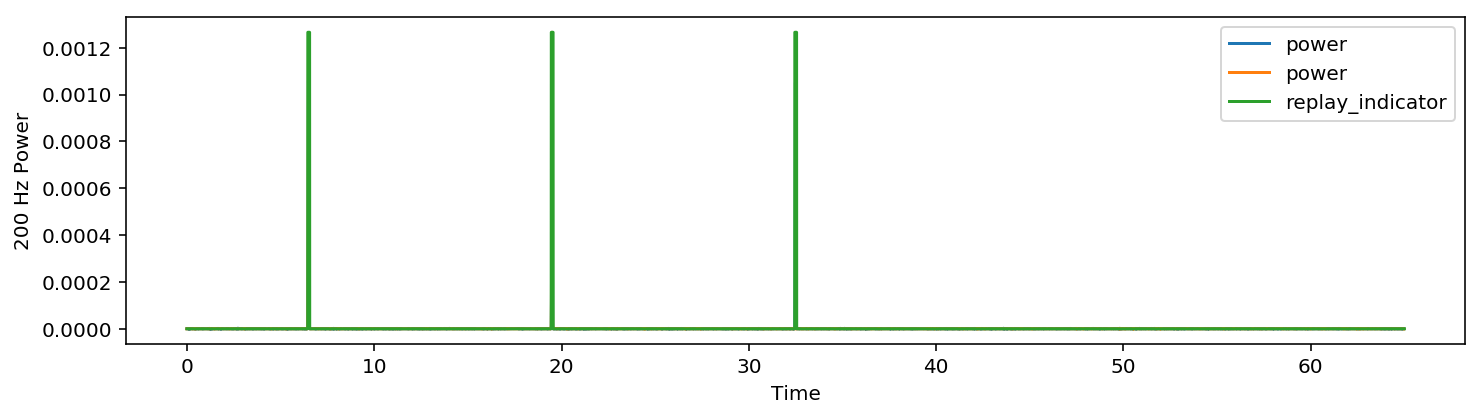

In [13]:
is_replay = np.zeros_like(time, dtype=bool)

for start, end in ripple_times:
    is_replay[(time >= start) & (time <= end)] = True
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(time, power, label='power');
ax.plot(time, is_replay * np.nanmax(power), label='replay_indicator', zorder=100)
ax.set_ylabel('200 Hz Power')
ax.set_xlabel('Time')
plt.legend();


## Decoder Scenarios

In [45]:
from replay_identification import ReplayDetector
from sklearn.neighbors import KernelDensity

r = ReplayDetector(replay_speed=100, place_bin_size=1,
                   multiunit_density_model=KernelDensity,
                   multiunit_model_kwargs=dict(bandwidth=4, leaf_size=1000))
r.fit(is_replay, speed, linear_distance, power, spikes, multiunit)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/regularized_glm/core.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  full_response * full_weights)[0]
INFO:replay_identification.decoders:Fitting multiunit model...


INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


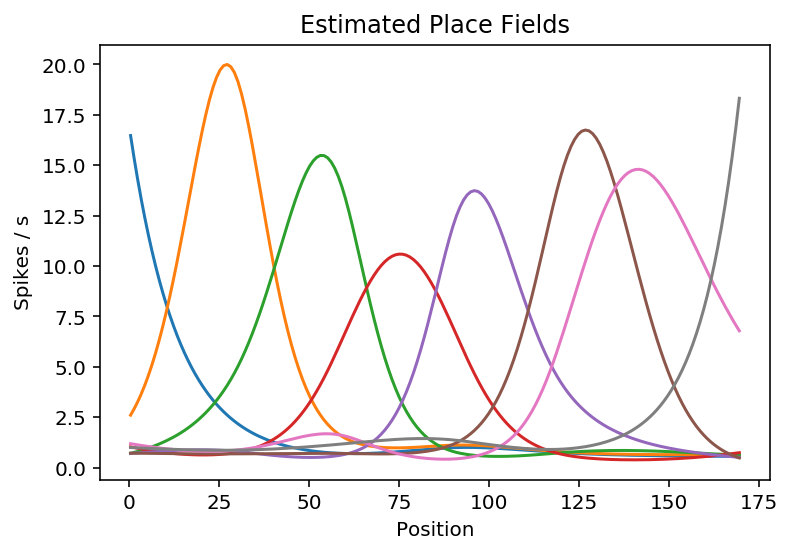

In [15]:
r.plot_fitted_place_fields(sampling_frequency=sampling_frequency)

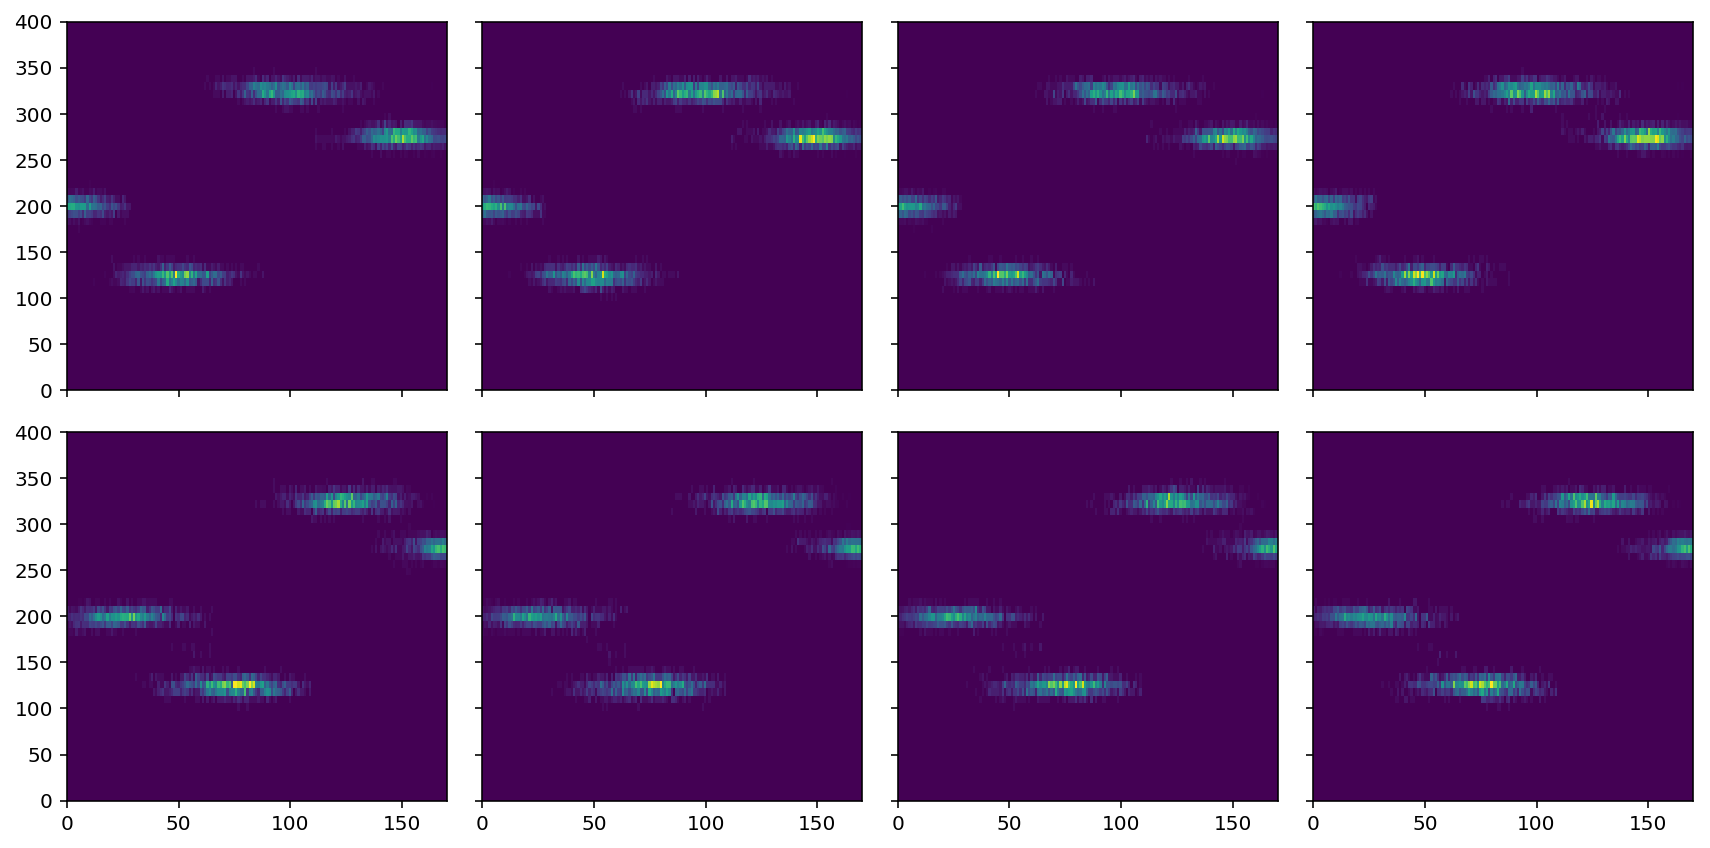

In [16]:
r.plot_fitted_multiunit_model(sampling_frequency, mark_edges=np.linspace(0, 400, 50), is_histogram=True);

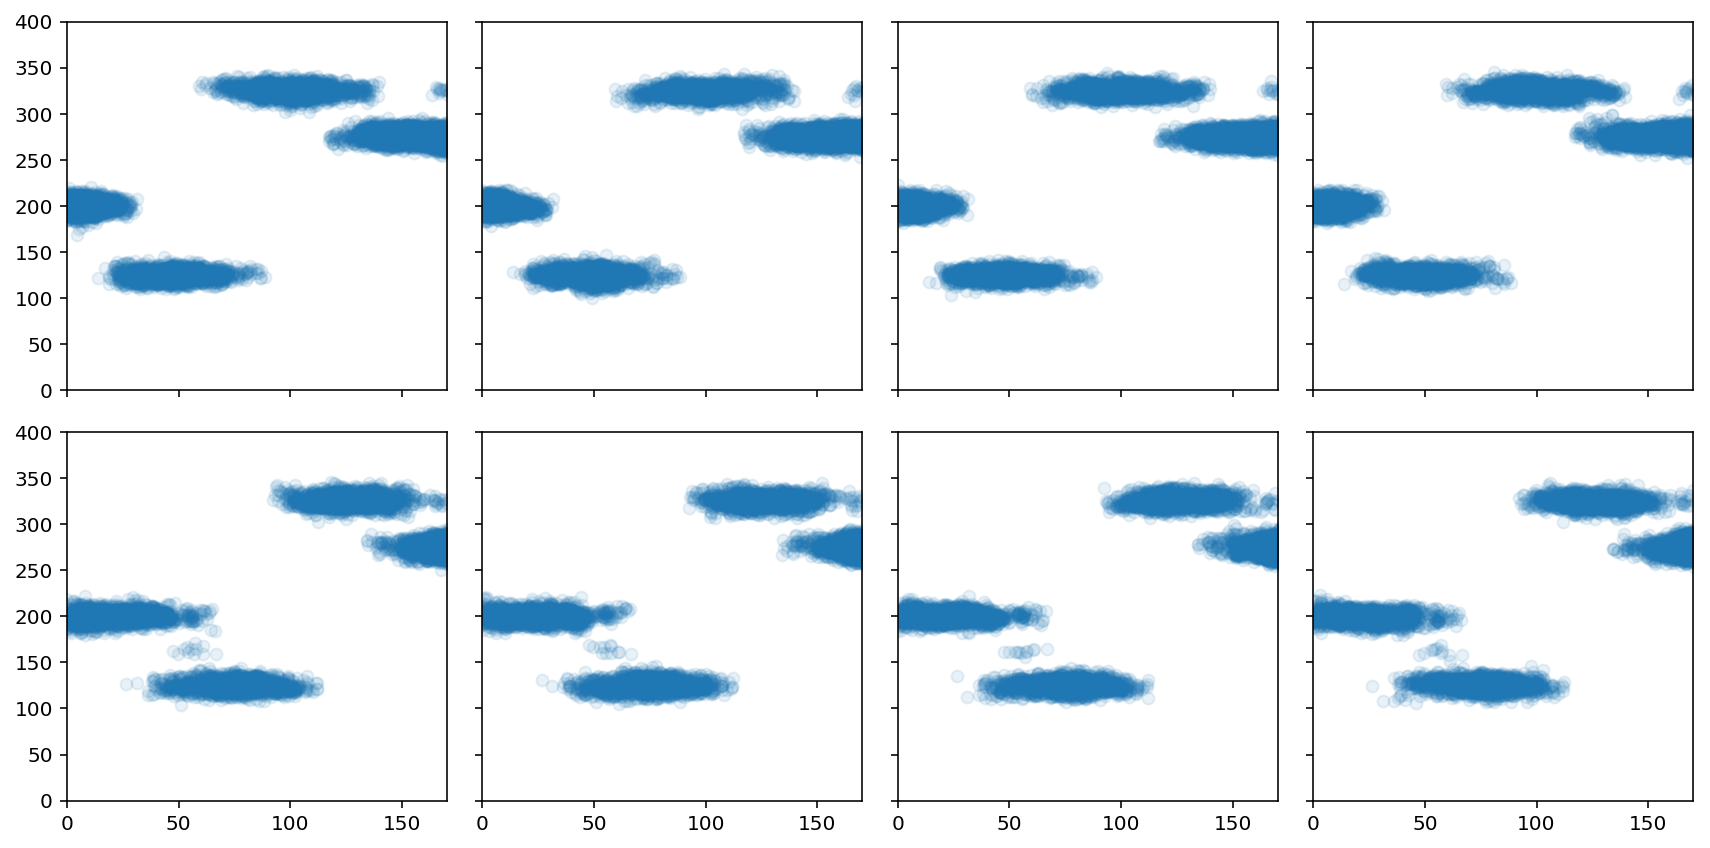

In [17]:
r.plot_fitted_multiunit_model();

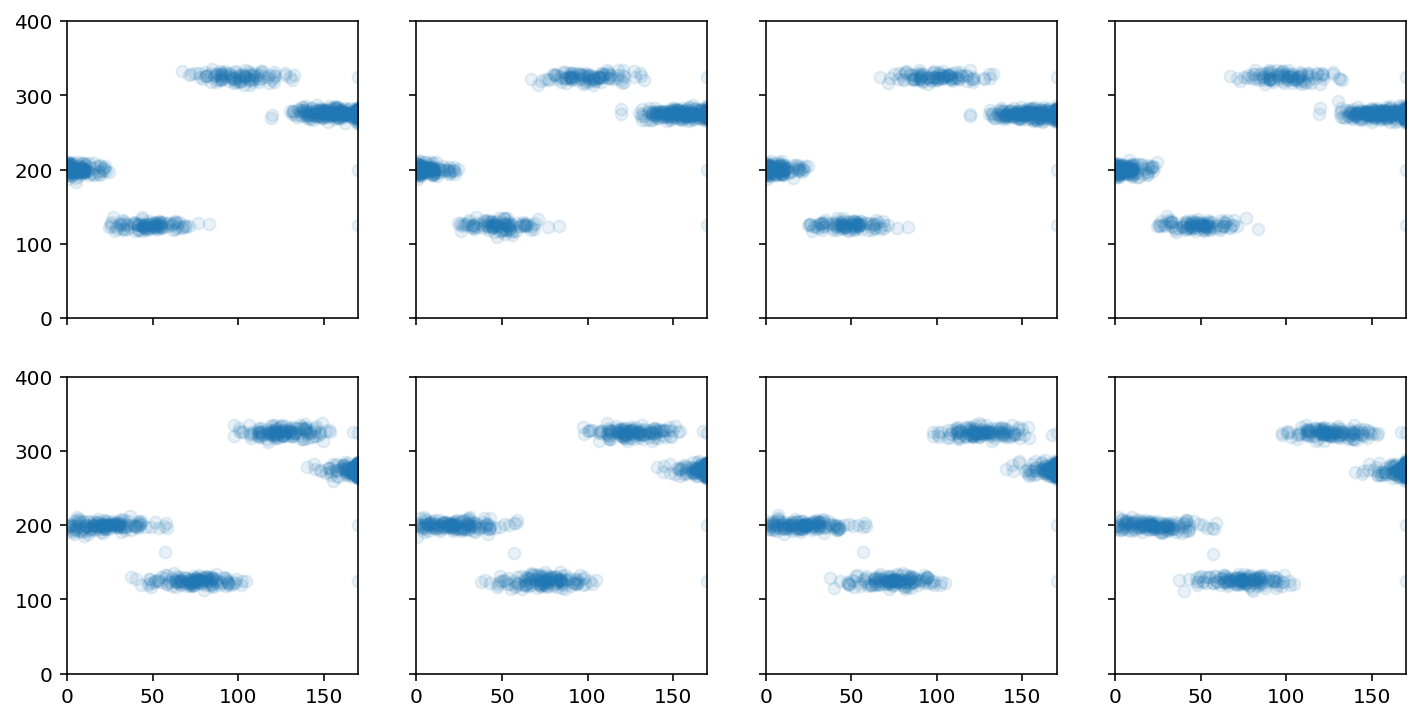

In [18]:
r.plot_multiunit(multiunit, linear_distance)

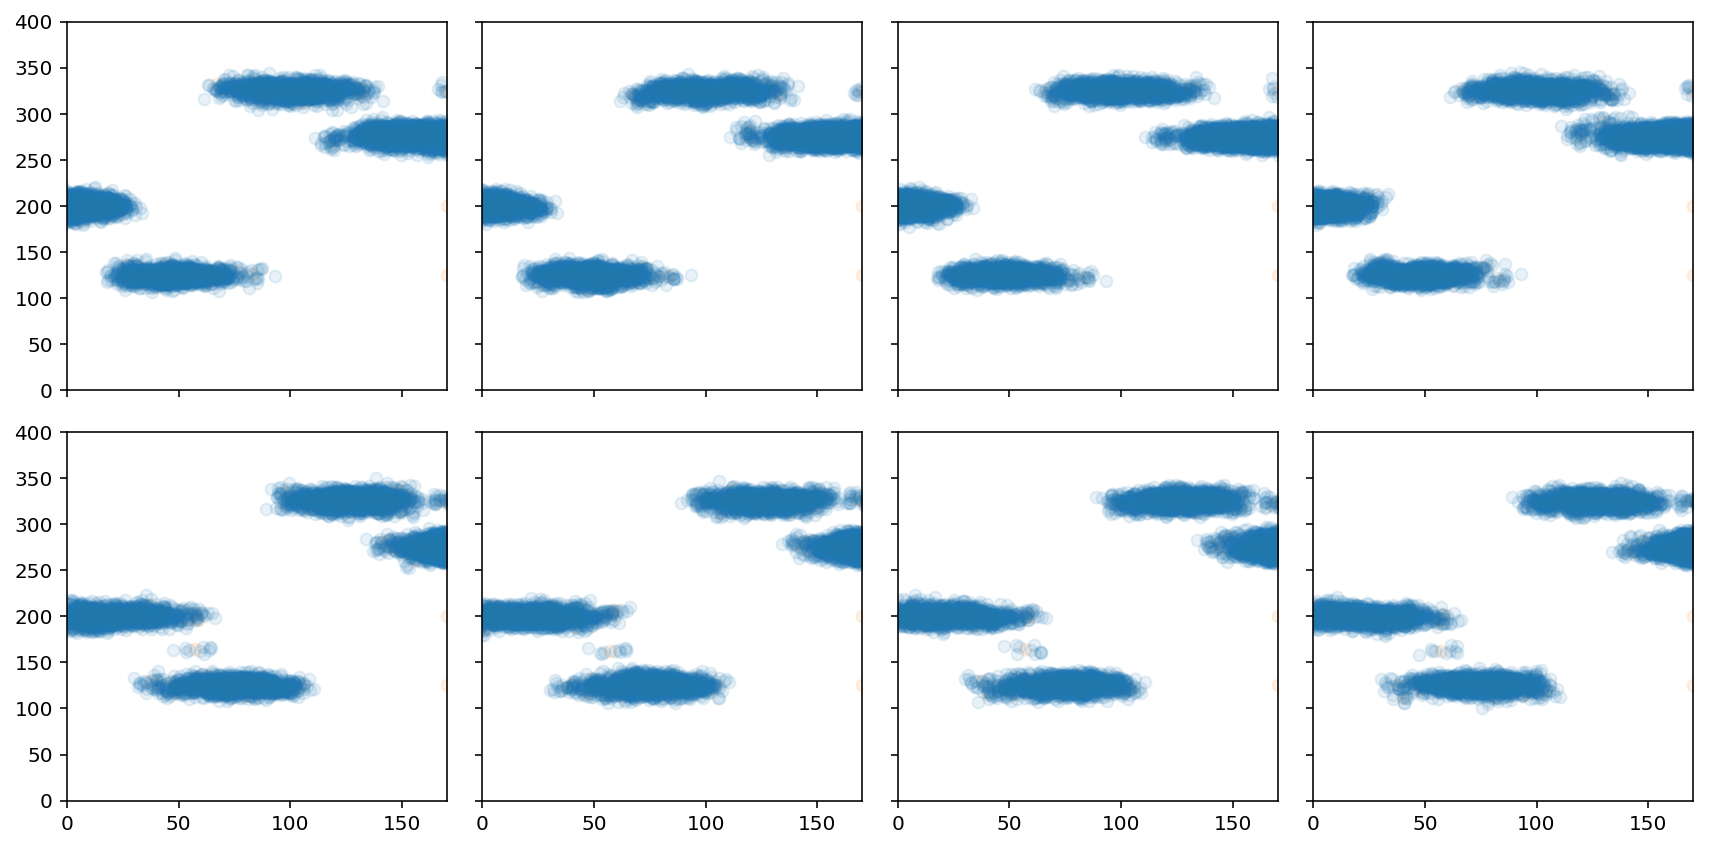

In [19]:
axes = r.plot_fitted_multiunit_model();
r.plot_multiunit(multiunit, linear_distance, axes)

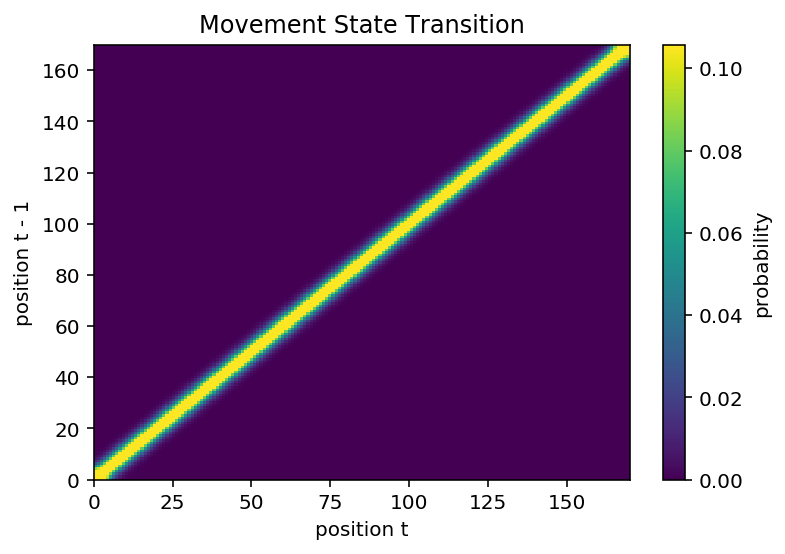

In [20]:
r.plot_movement_state_transition()

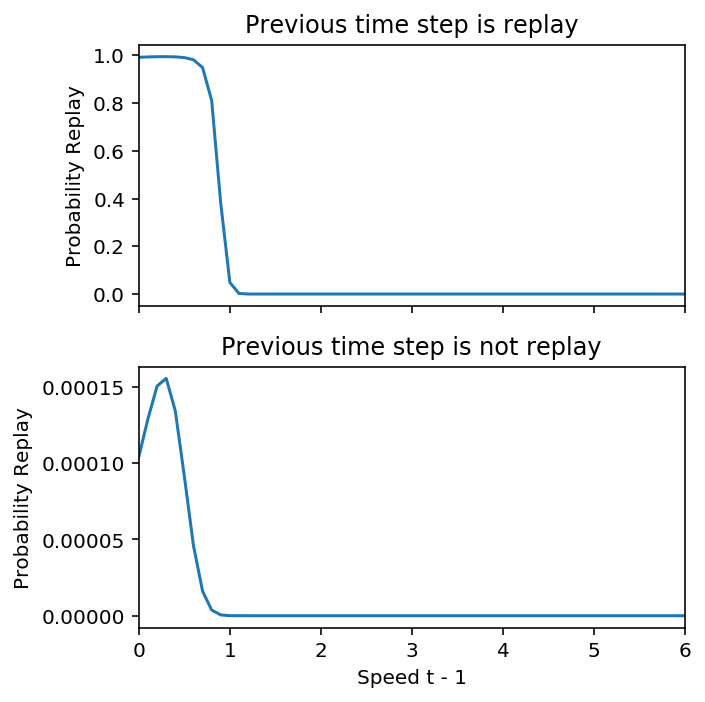

In [21]:
r.plot_replay_state_transition()
plt.xlim((0, 6));

### Spikes, LFP Power, and Speed

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


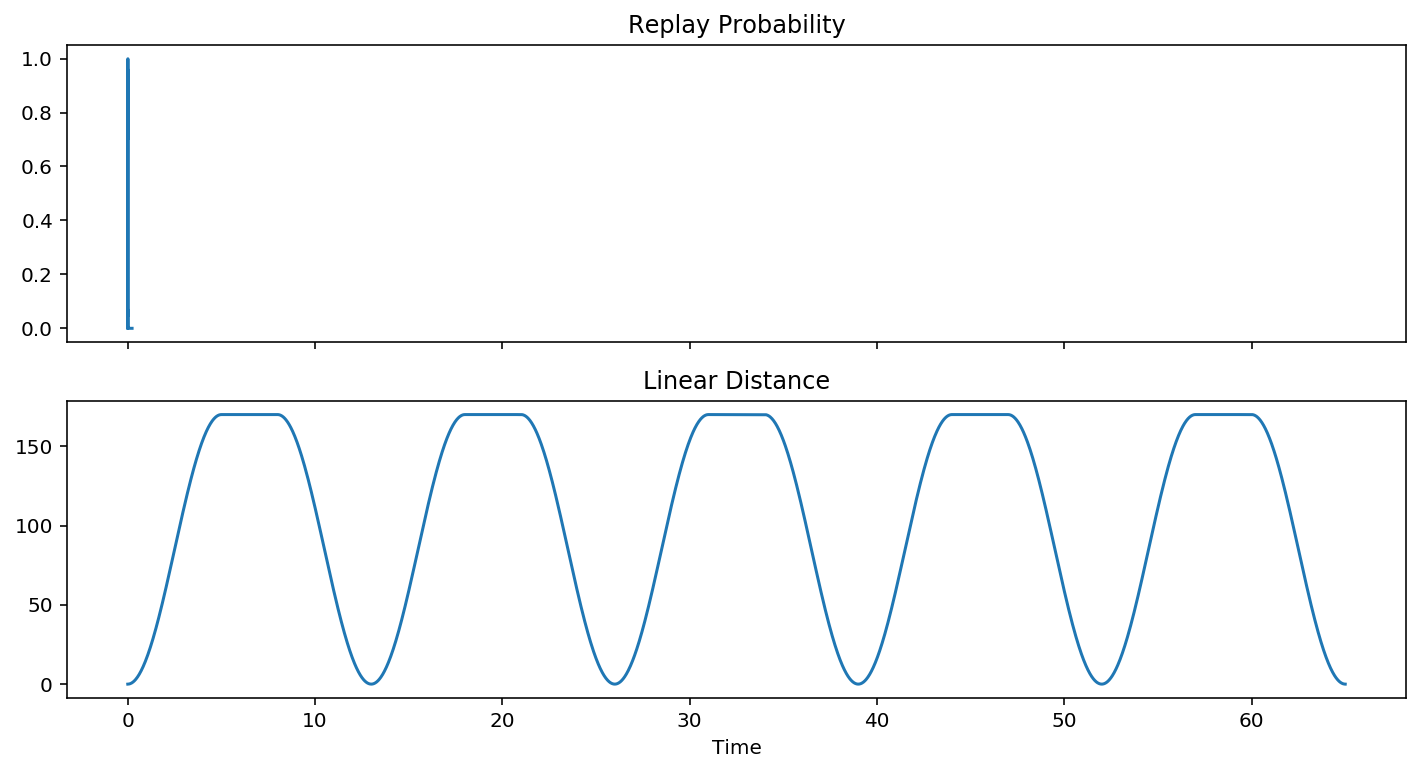

In [22]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

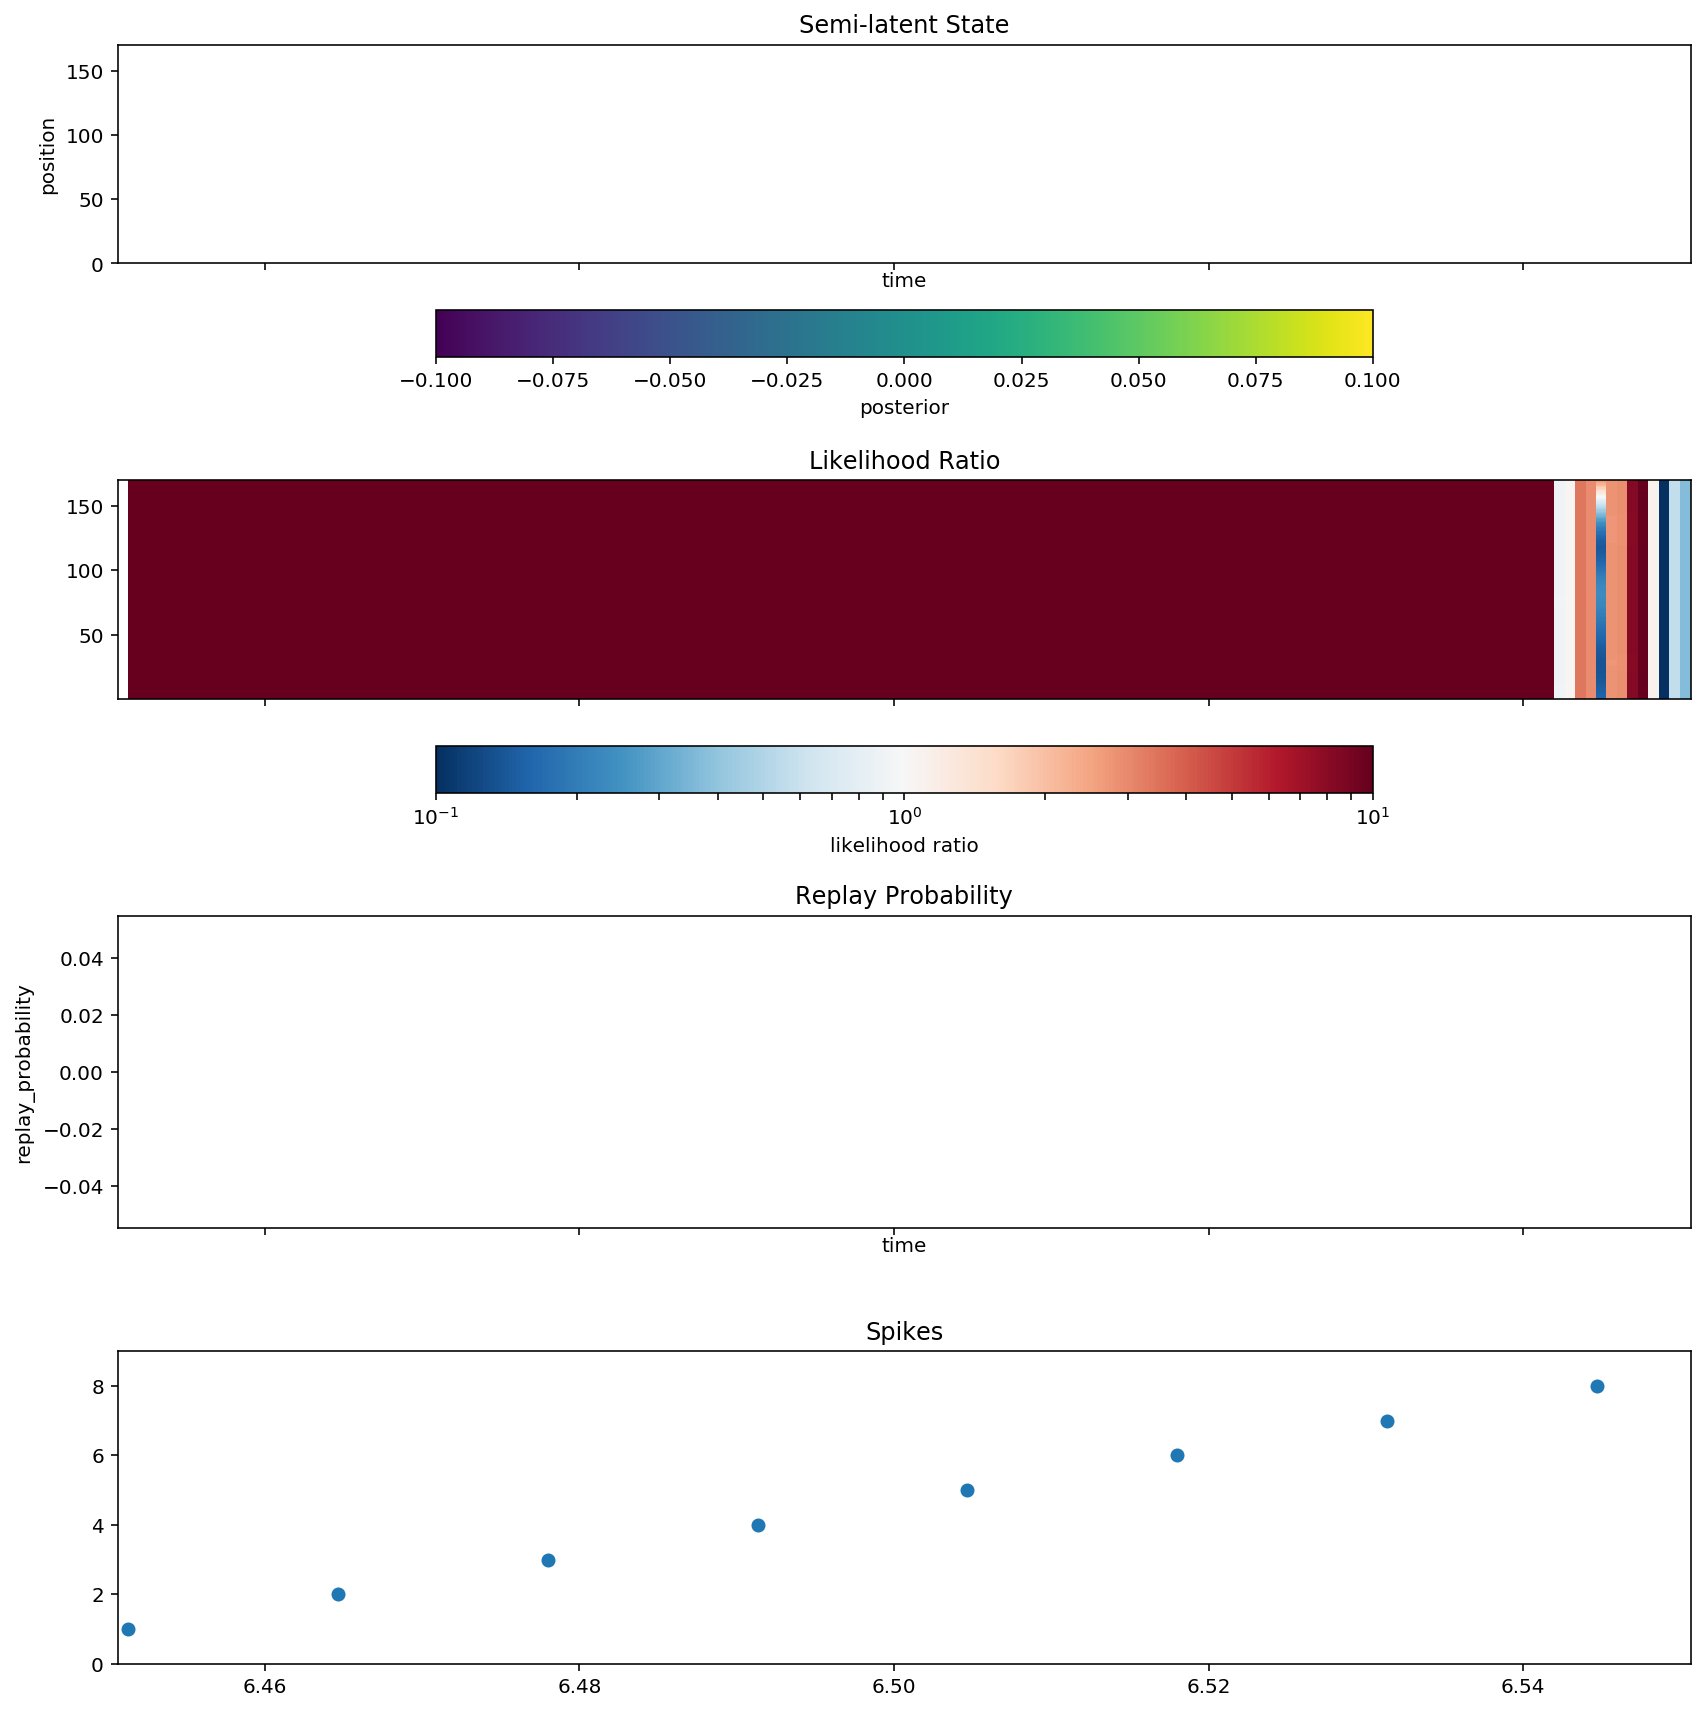

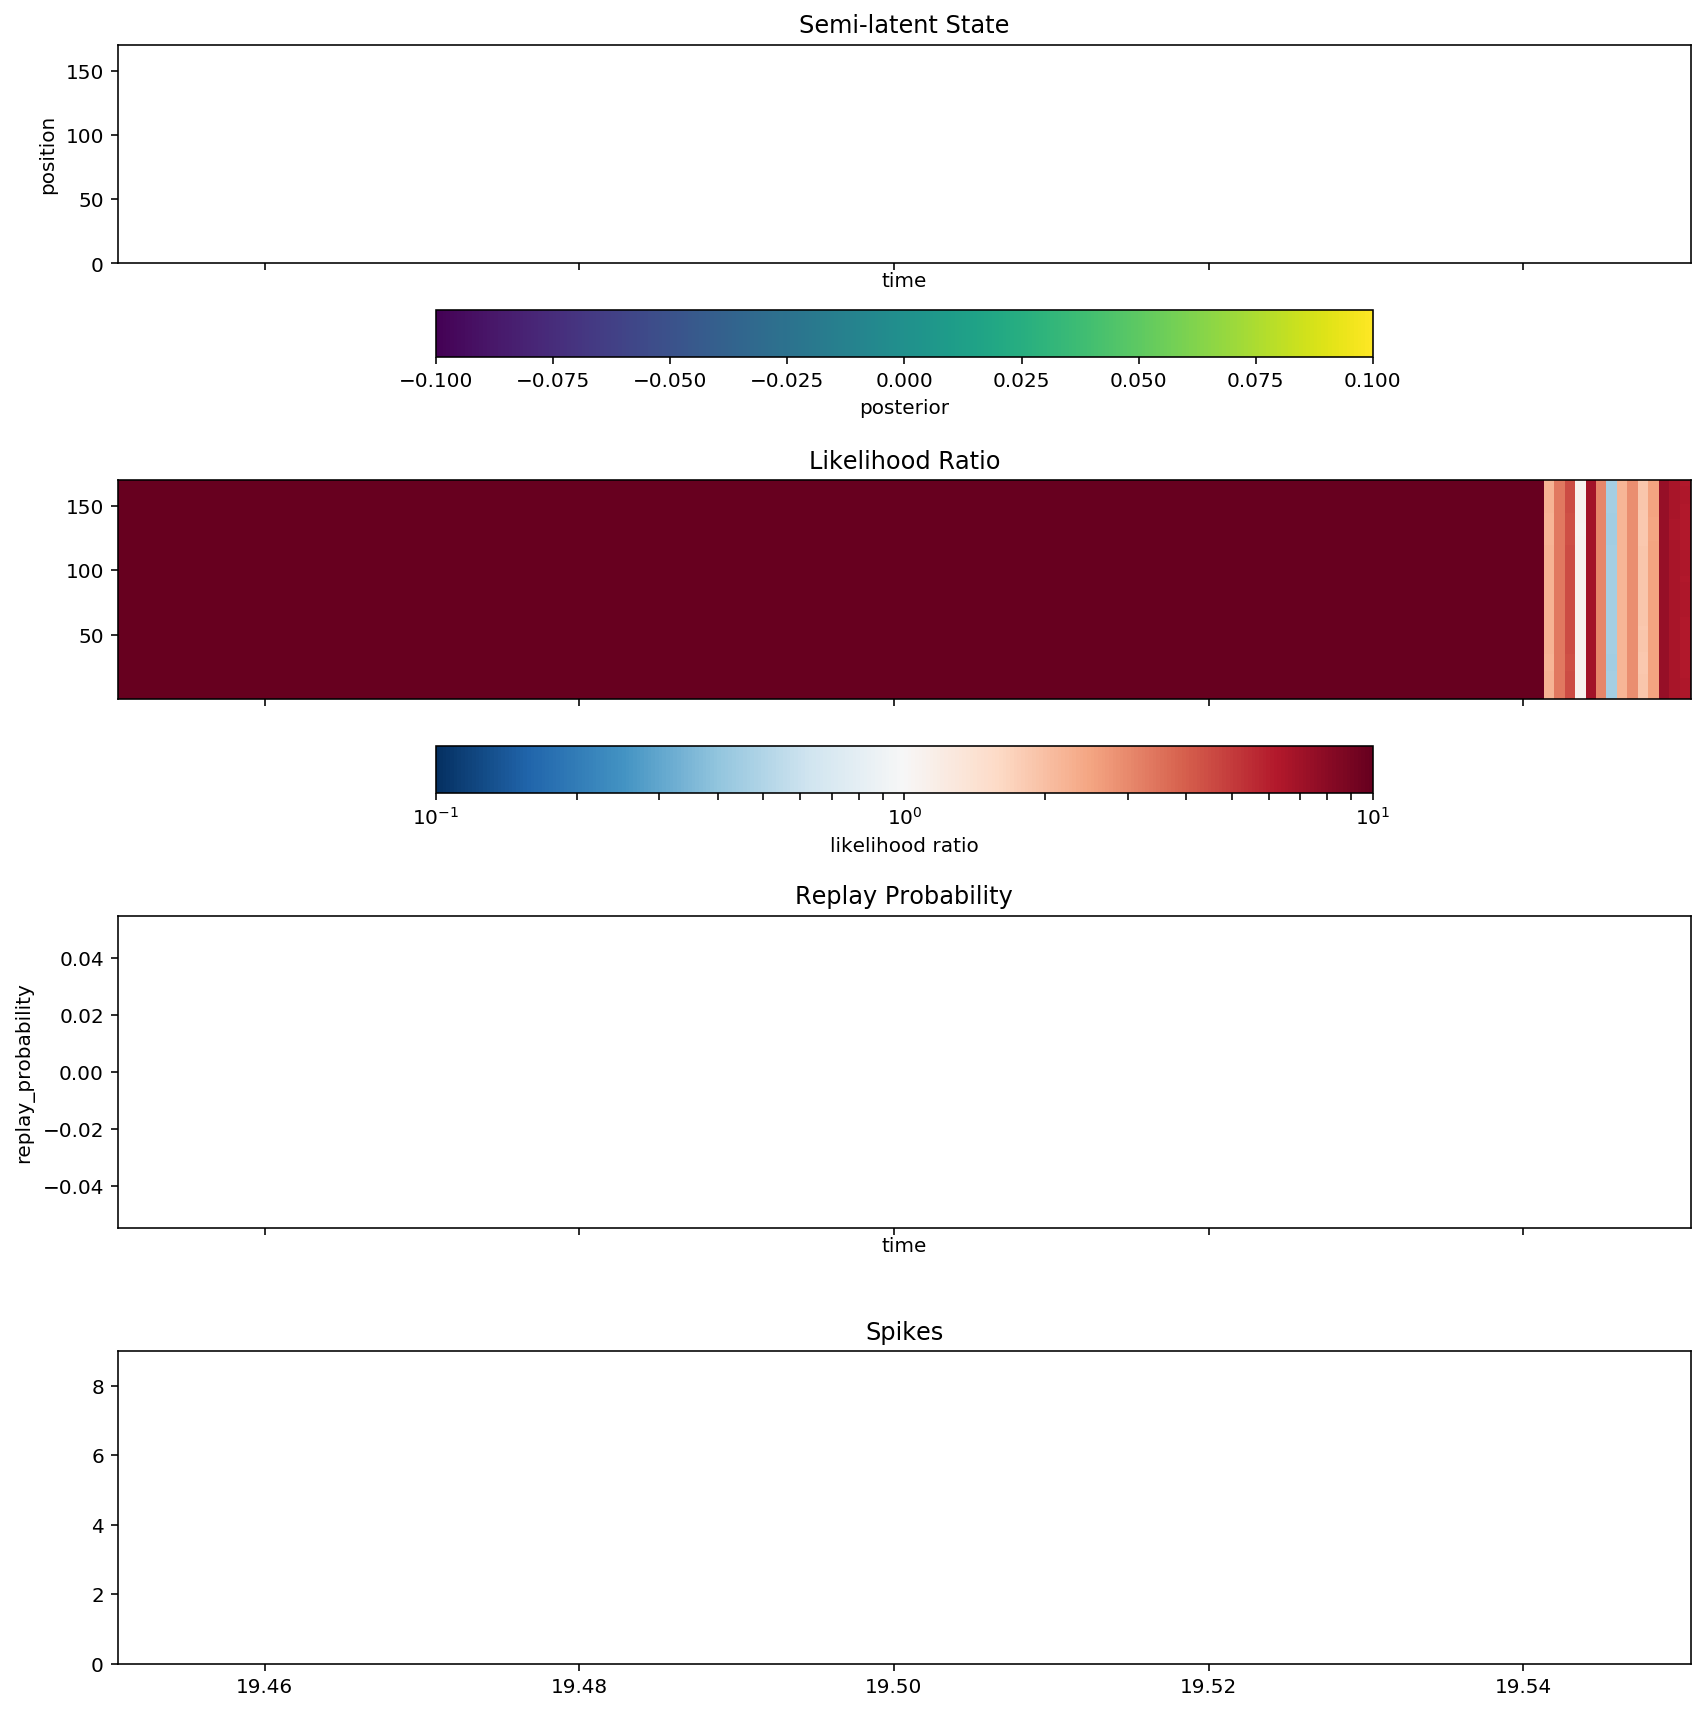

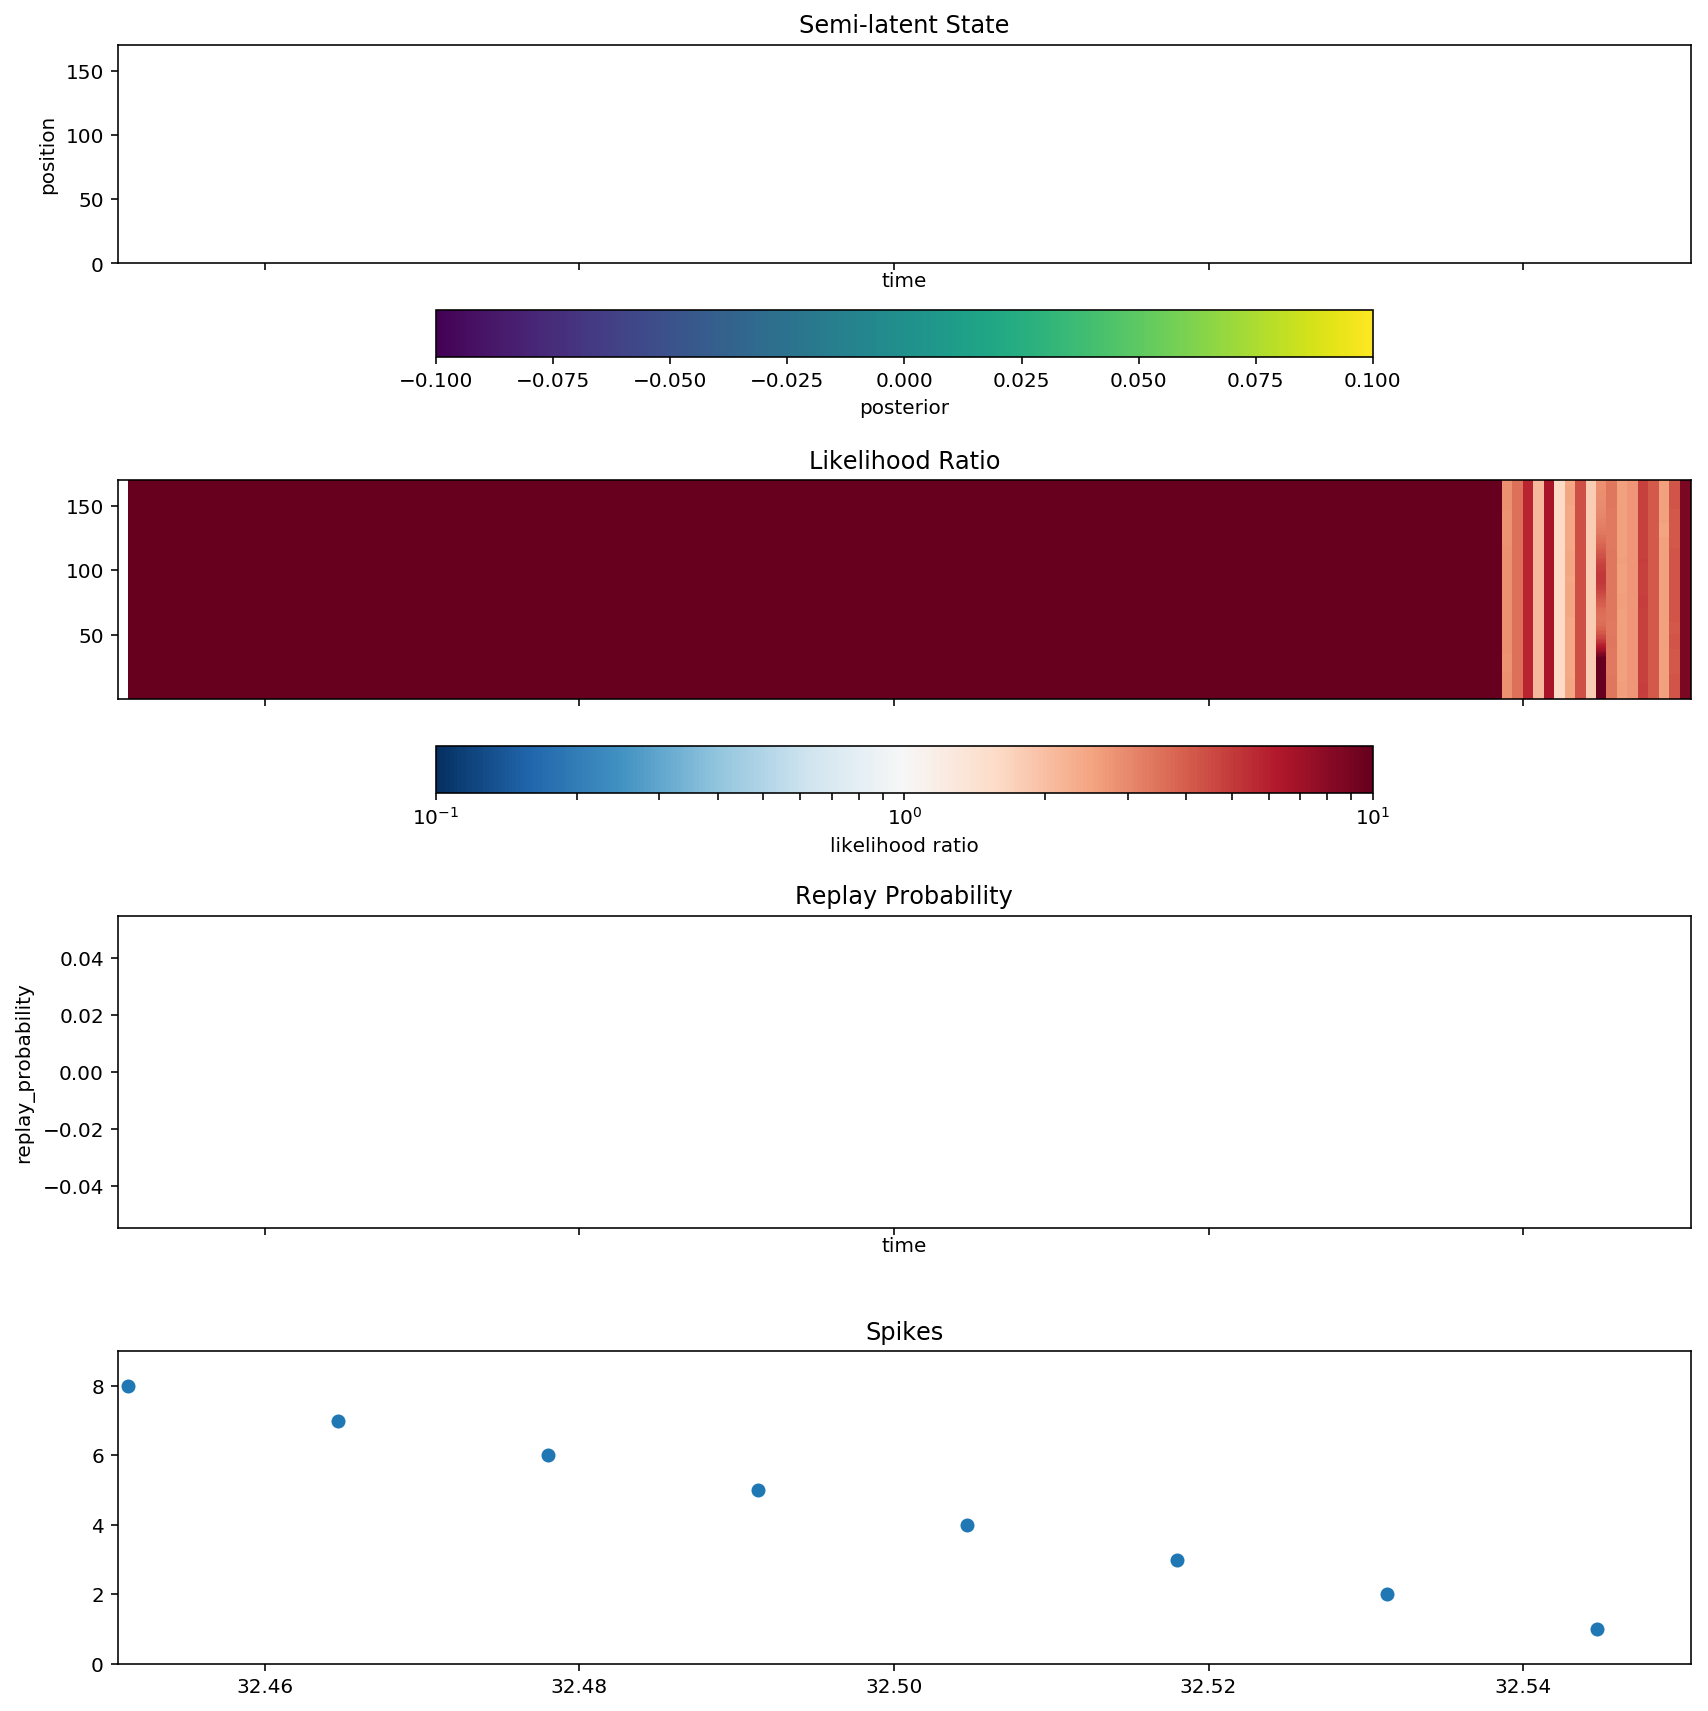

In [23]:
import matplotlib.colors as colors

spike_ind, neuron_ind = np.nonzero(spikes)
vmin, vmax = 0.1, 10

for ripple_ind, (start_time, end_time) in enumerate(ripple_times):
    start_ind, end_ind = np.searchsorted(time, [start_time, end_time])
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    results.replay_posterior.sel(time=slice(start_time, end_time)).plot(
            x='time', y='position',
        cbar_kwargs=dict(orientation='horizontal', label='posterior'), ax=axes[0])
    axes[0].set_title('Semi-latent State')
    likelihood = results.likelihood.sel(time=slice(start_time, end_time))
    t, p = likelihood.time, likelihood.position
    t, p = np.meshgrid(t, p)
    cax = axes[1].pcolormesh(
        t, p,
        likelihood.values.T,
        norm=colors.LogNorm(vmin, vmax), cmap='RdBu_r')
    axes[1].set_title('Likelihood Ratio')
    plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='horizontal')
    results.replay_probability.sel(time=slice(start_time, end_time)).plot(ax=axes[2])
    axes[2].set_title('Replay Probability')
    in_spike_ind = (spike_ind >= start_ind) & (spike_ind <= end_ind)
    
    axes[3].scatter(time[spike_ind[in_spike_ind]], neuron_ind[in_spike_ind] + 1)
    axes[3].set_title('Spikes')
    axes[3].set_ylim((0, n_neurons + 1))
    plt.xlim((start_time, end_time))
    fig.tight_layout()

### Spikes Only

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/regularized_glm/core.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  full_response * full_weights)[0]
INFO:replay_identification.decoders:Fitting multiunit model...


INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


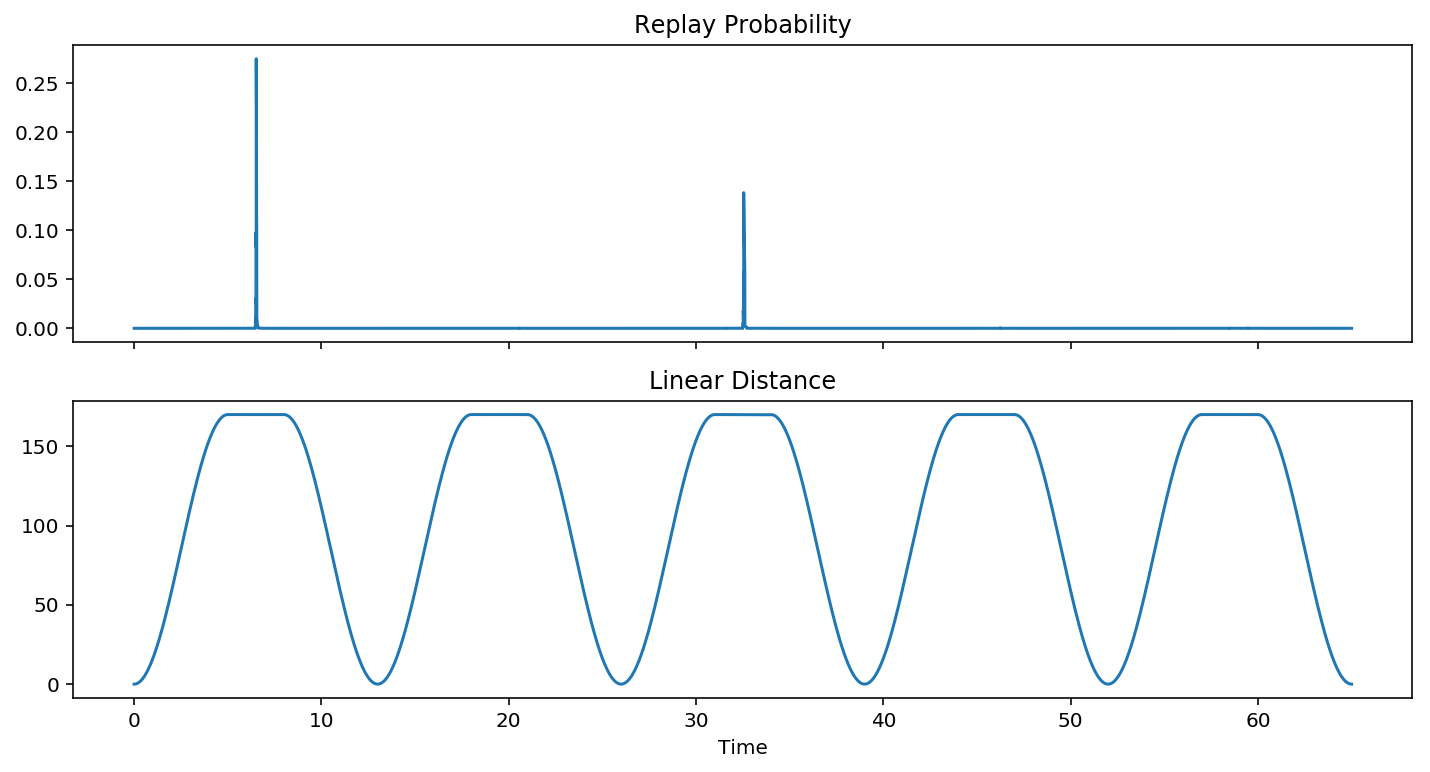

In [84]:
from replay_identification import ReplayDetector
from sklearn.neighbors import KernelDensity

r = ReplayDetector(replay_speed=20, place_bin_size=1,
                   multiunit_density_model=KernelDensity,
                   multiunit_model_kwargs=dict(bandwidth=4, leaf_size=1000))
r.fit(is_replay, speed, linear_distance, power, spikes, multiunit)


results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['spikes'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

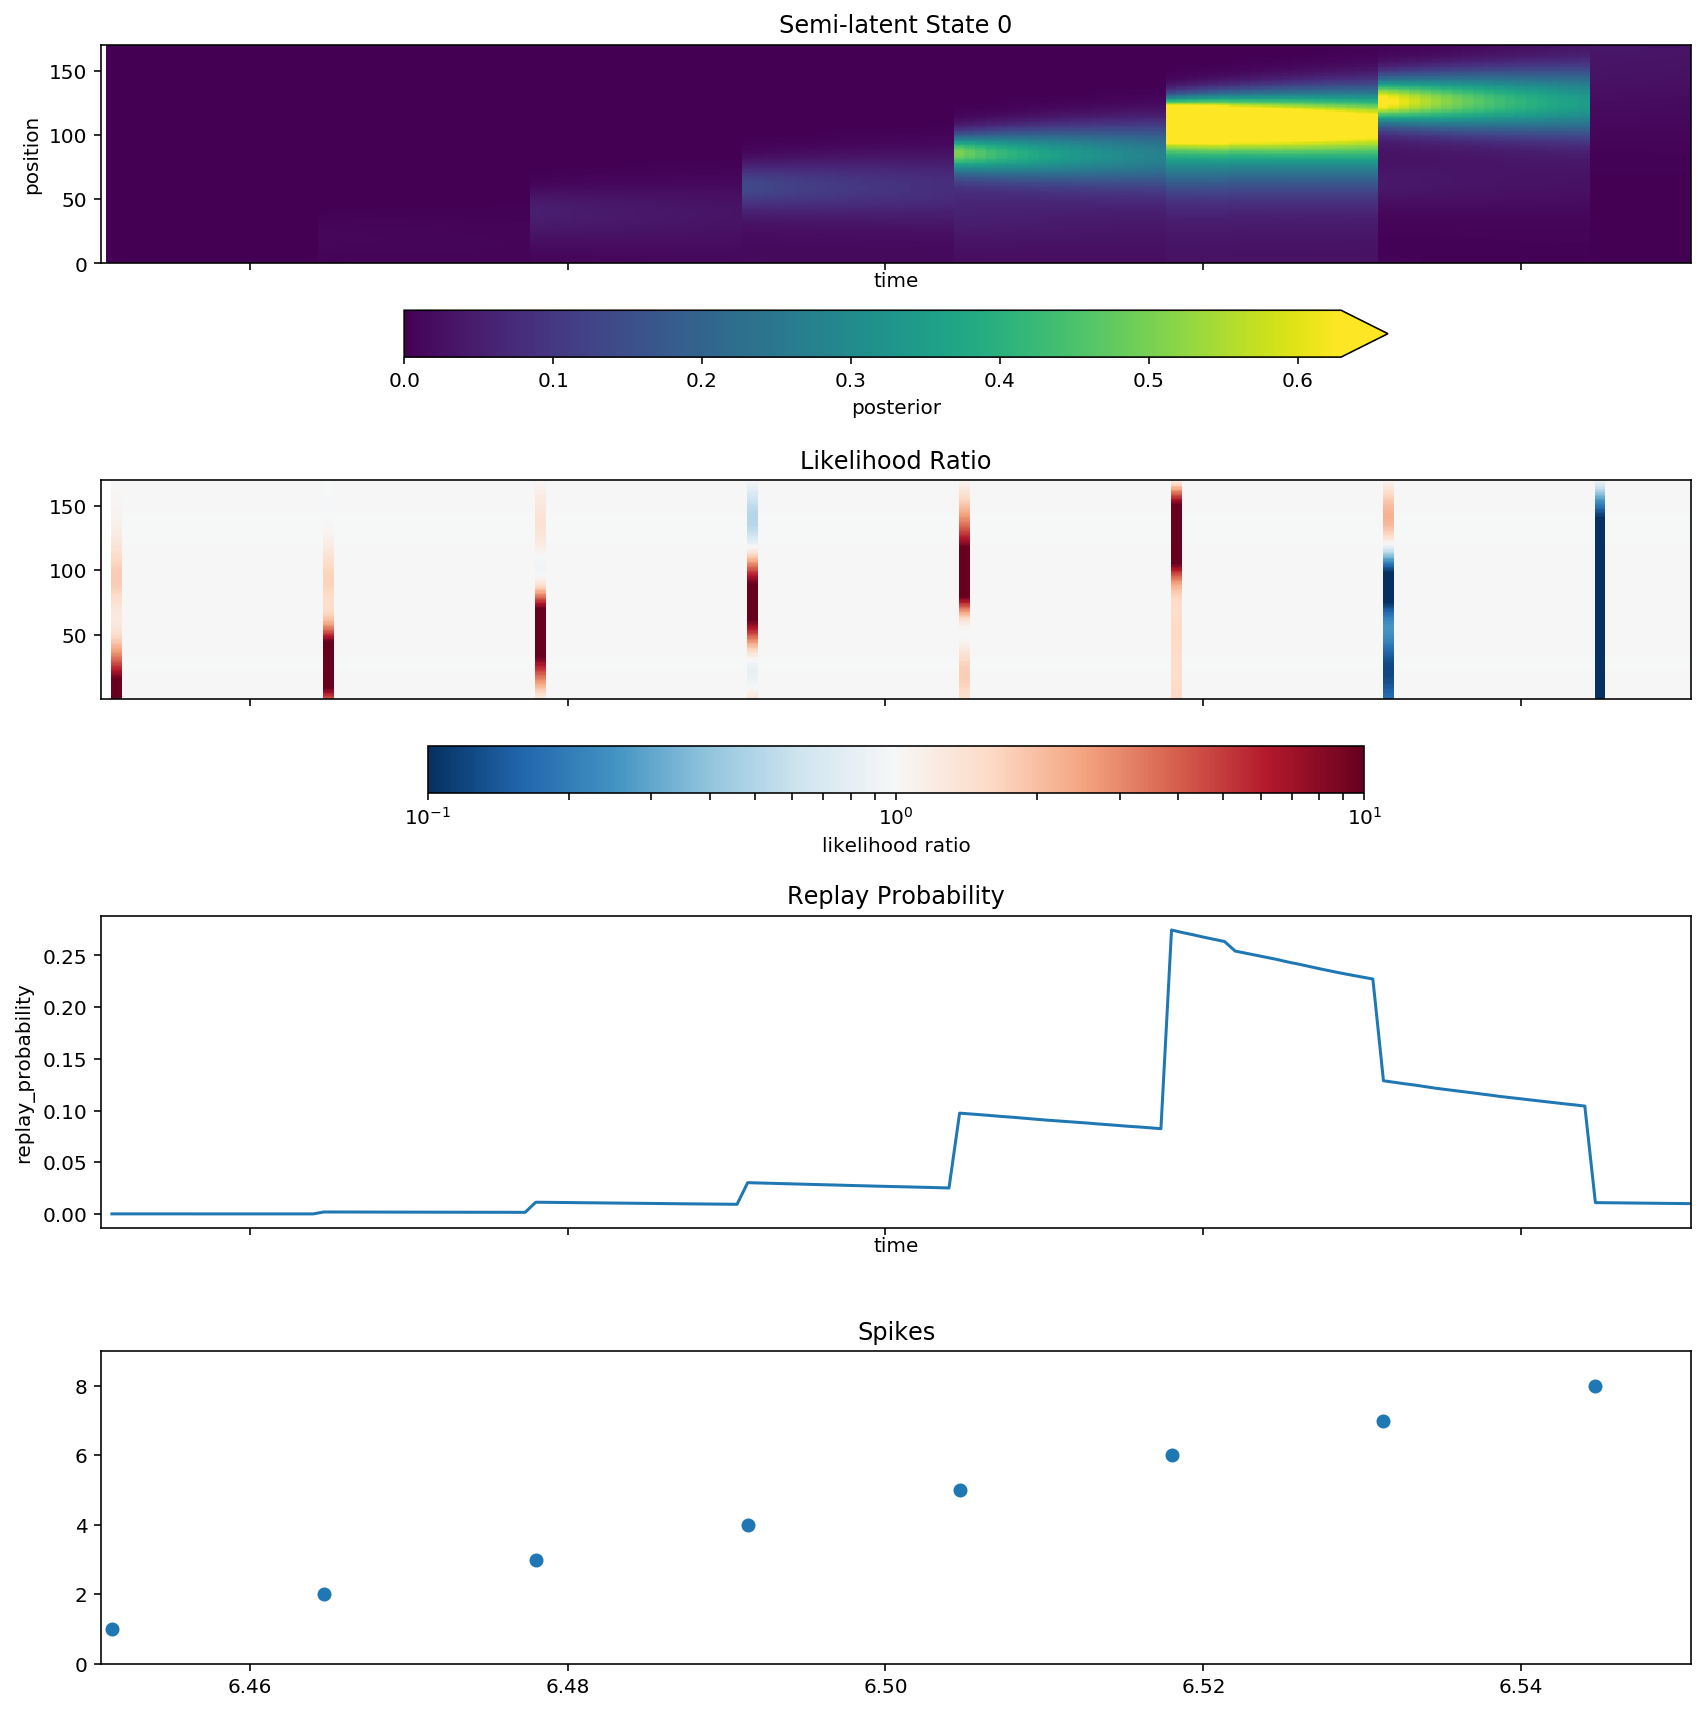

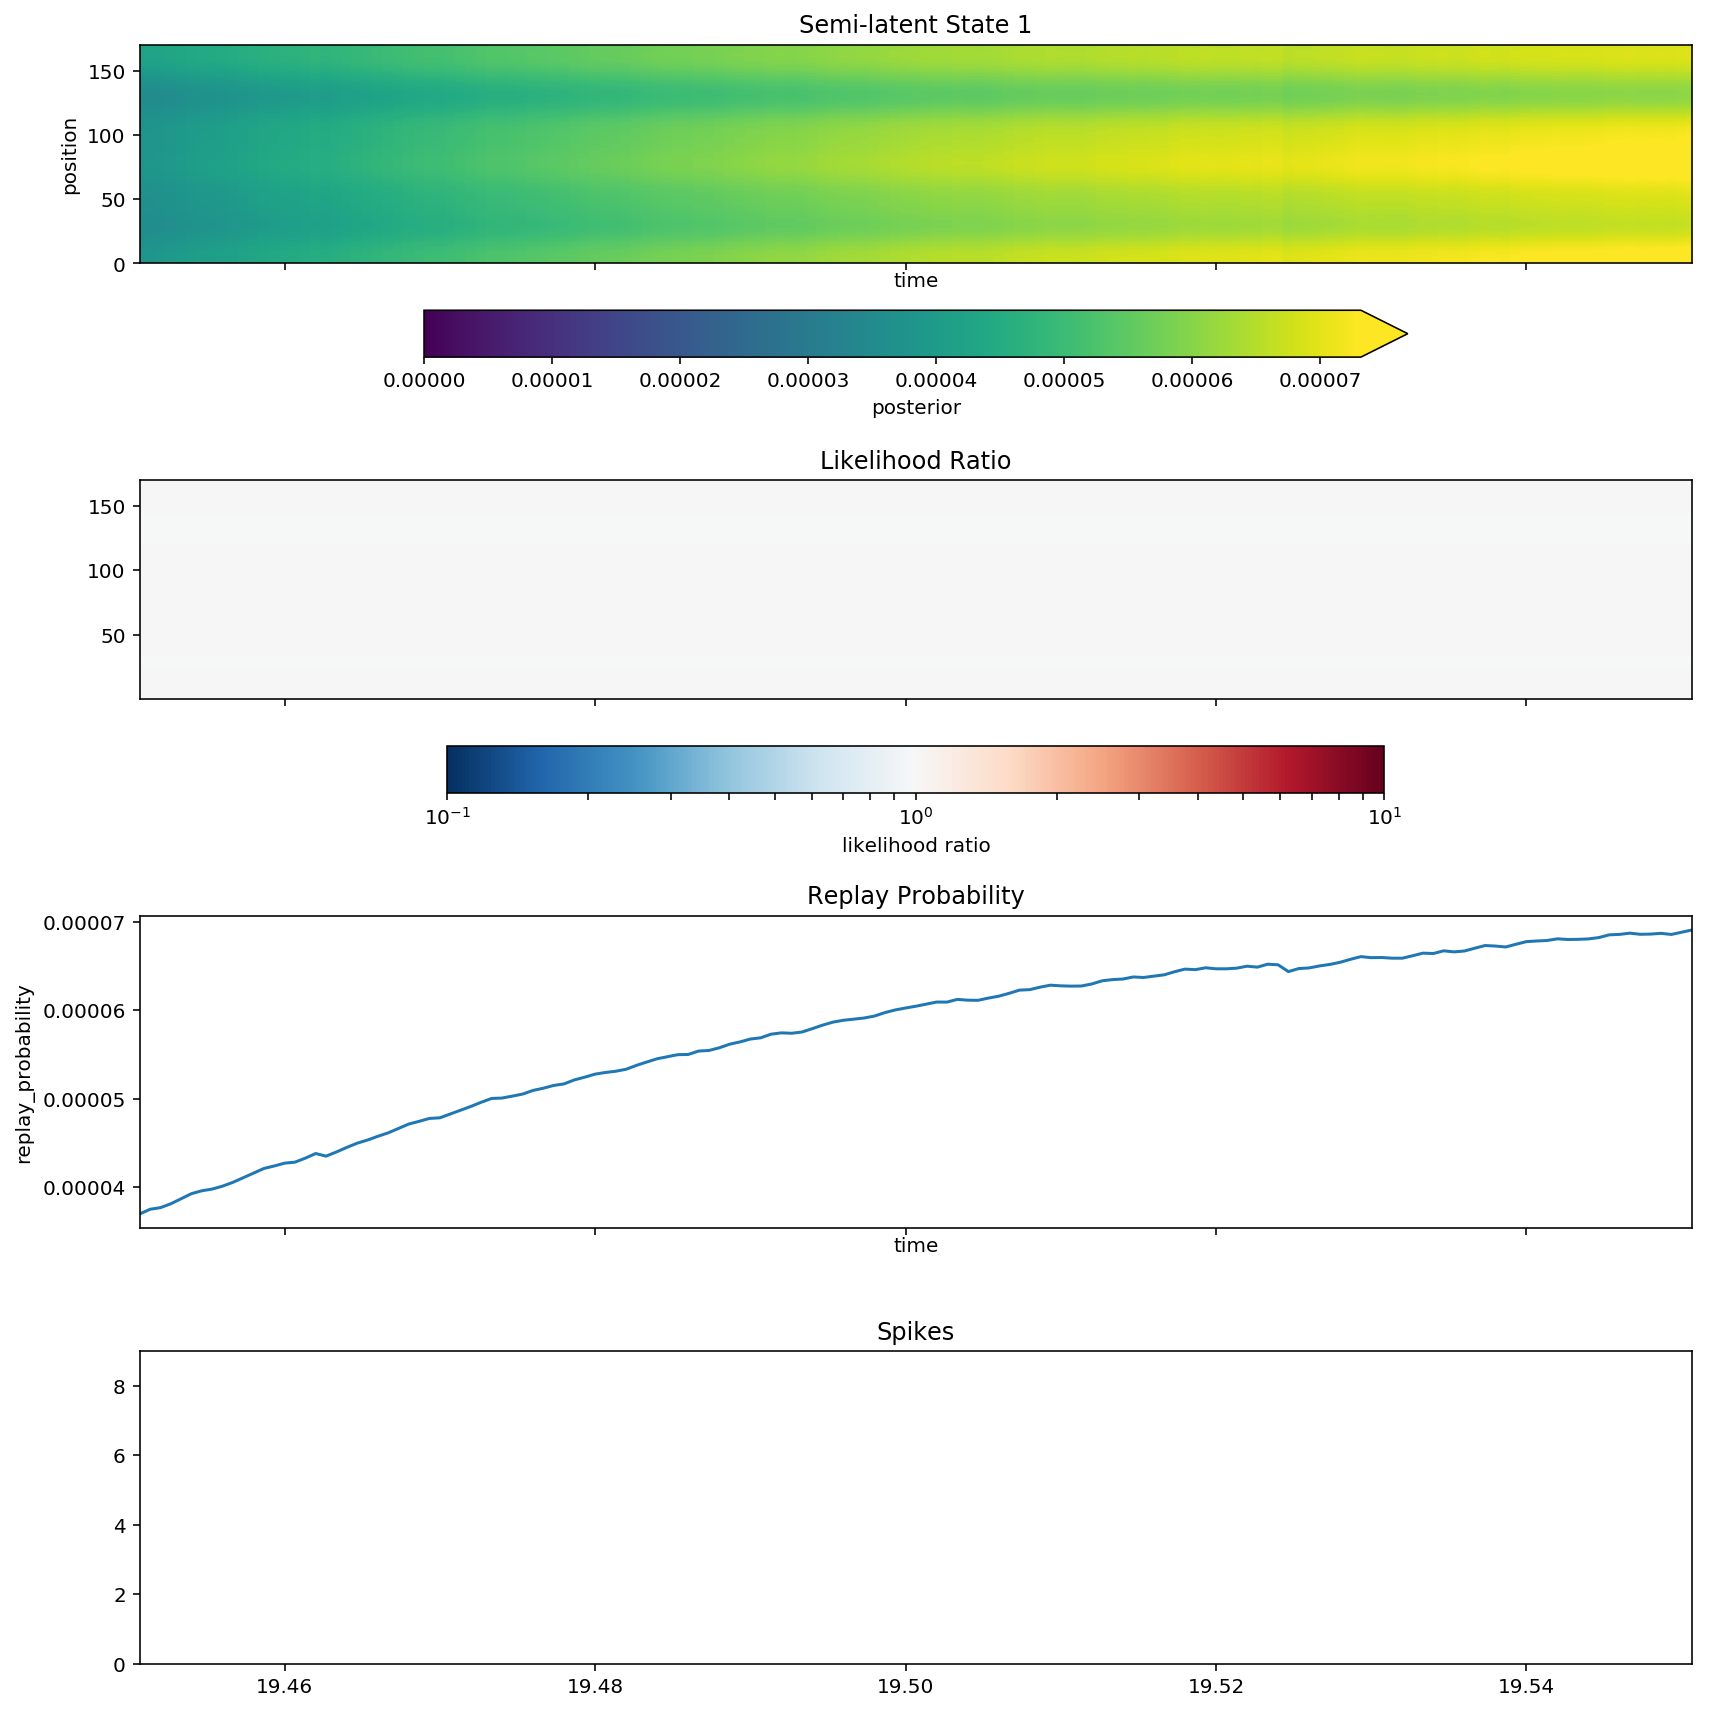

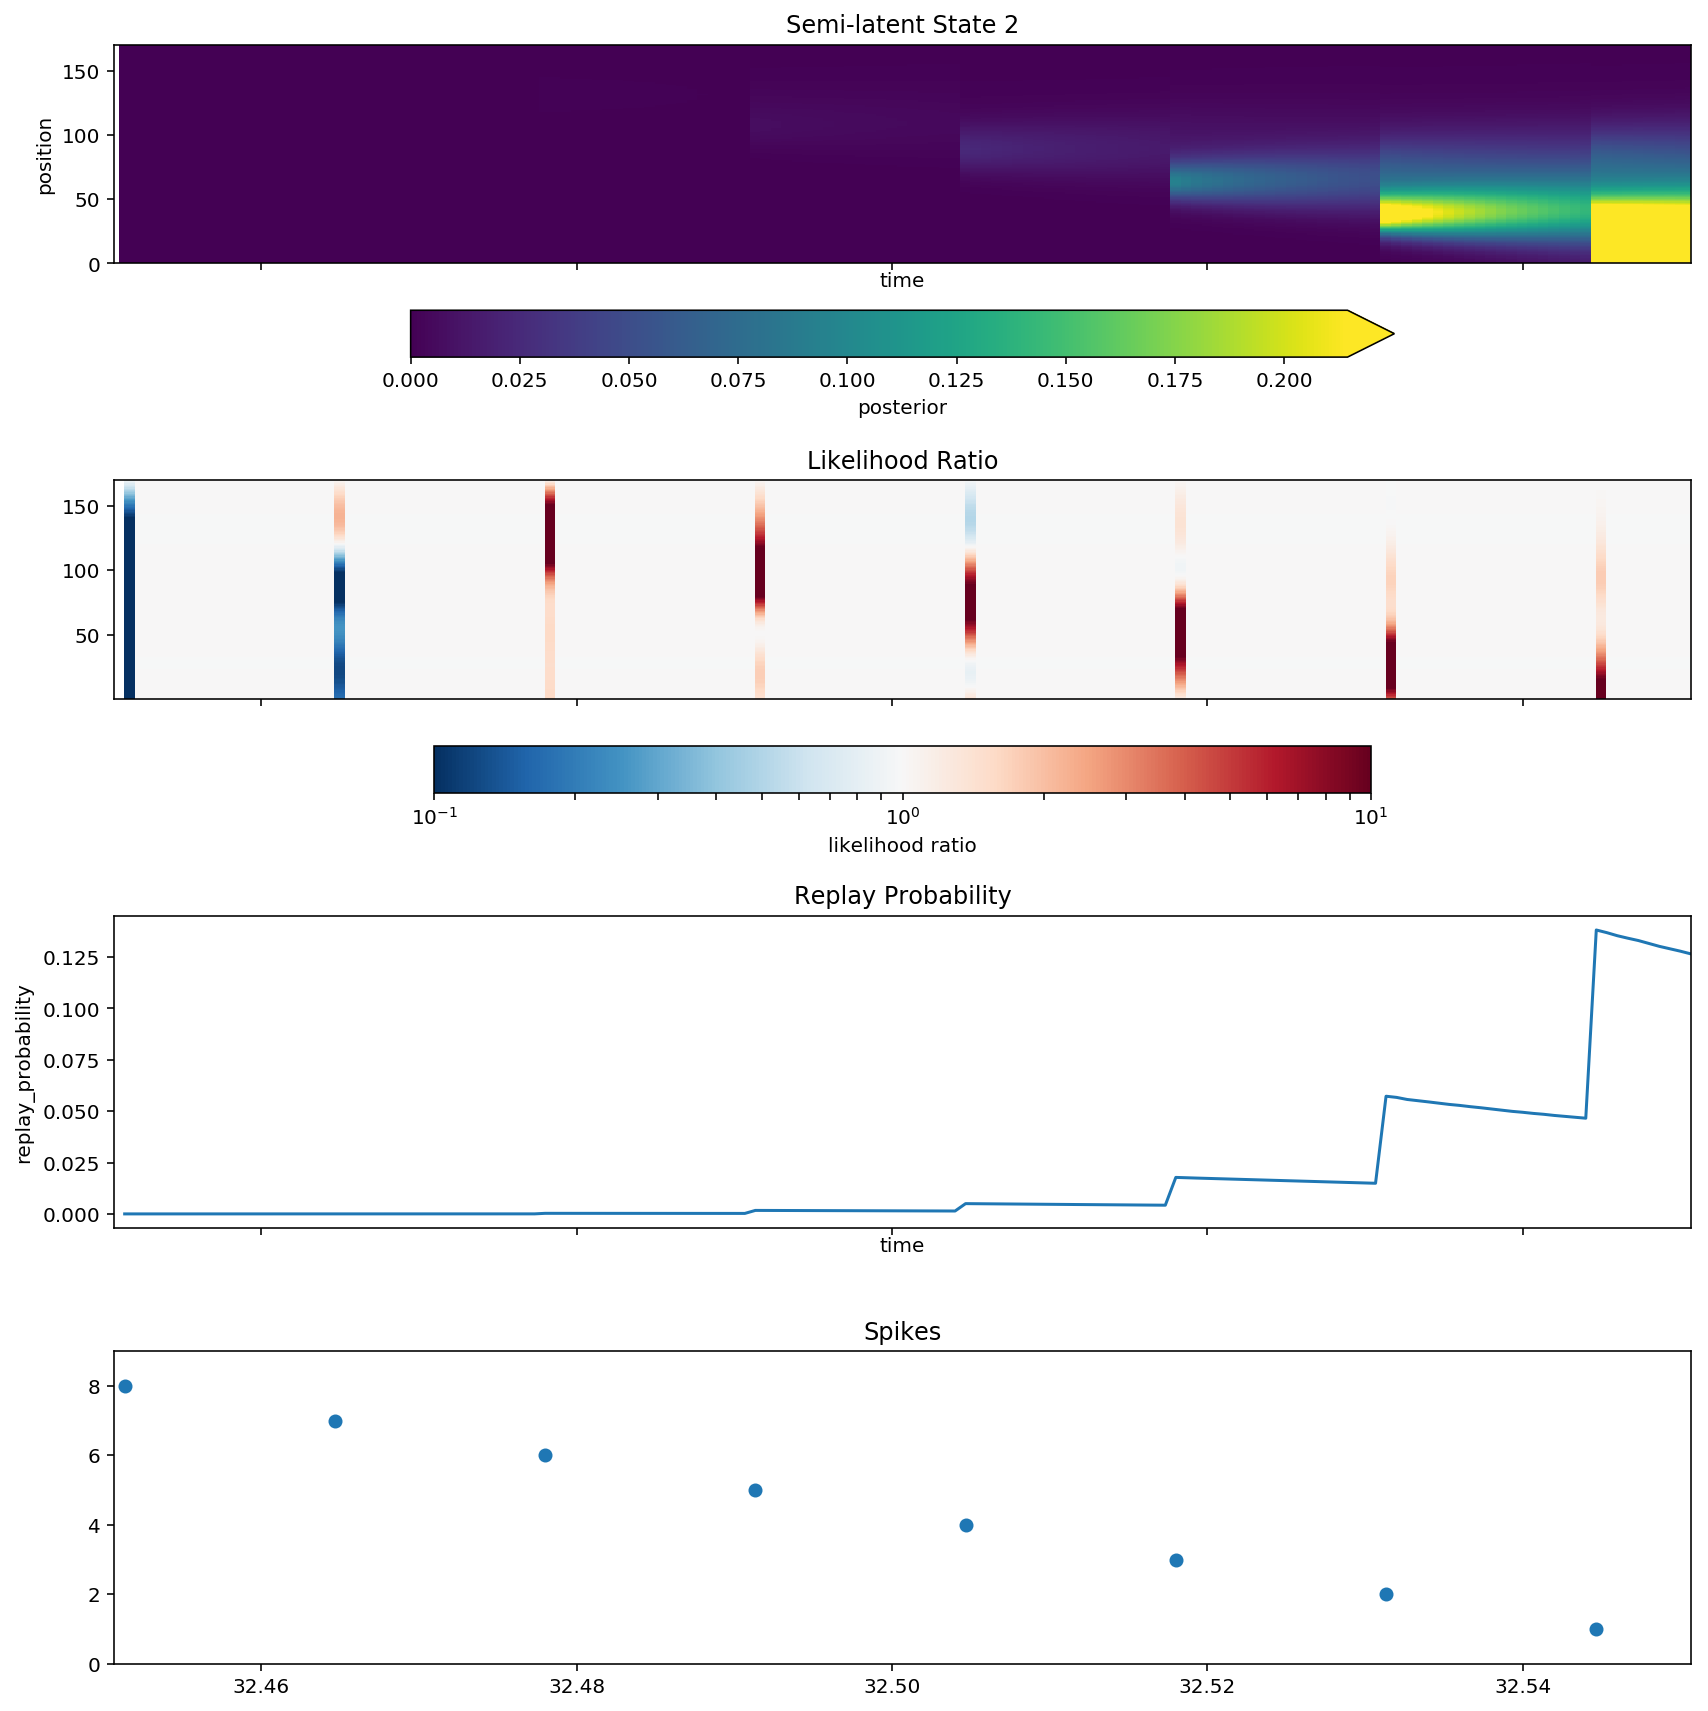

In [85]:
import matplotlib.colors as colors

spike_ind, neuron_ind = np.nonzero(spikes)
vmin, vmax = 0.1, 10


for ripple_ind, (start_time, end_time) in enumerate(ripple_times):
    start_ind, end_ind = np.searchsorted(time, [start_time, end_time])
    ripple_results = results.sel(time=slice(start_time, end_time))
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    ripple_results.replay_posterior.plot(
            x='time', y='position', vmin=0.0, robust=True,
        cbar_kwargs=dict(orientation='horizontal', label='posterior'), ax=axes[0])
    axes[0].set_title('Semi-latent State ' + str(ripple_ind))
    likelihood = ripple_results.likelihood
    t, p = likelihood.time, likelihood.position
    t, p = np.meshgrid(t, p)
    cax = axes[1].pcolormesh(t, p, likelihood.values.T,
                             norm=colors.LogNorm(vmin, vmax), cmap='RdBu_r')
    axes[1].set_title('Likelihood Ratio')
    plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='horizontal')
    ripple_results.replay_probability.plot(ax=axes[2])
    axes[2].set_title('Replay Probability')
    in_spike_ind = (spike_ind >= start_ind) & (spike_ind <= end_ind)
    
    axes[3].scatter(time[spike_ind[in_spike_ind]], neuron_ind[in_spike_ind] + 1)
    axes[3].set_title('Spikes')
    axes[3].set_ylim((0, n_neurons + 1))
    plt.xlim((start_time, end_time))
    fig.tight_layout()

### LFP Power Only

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


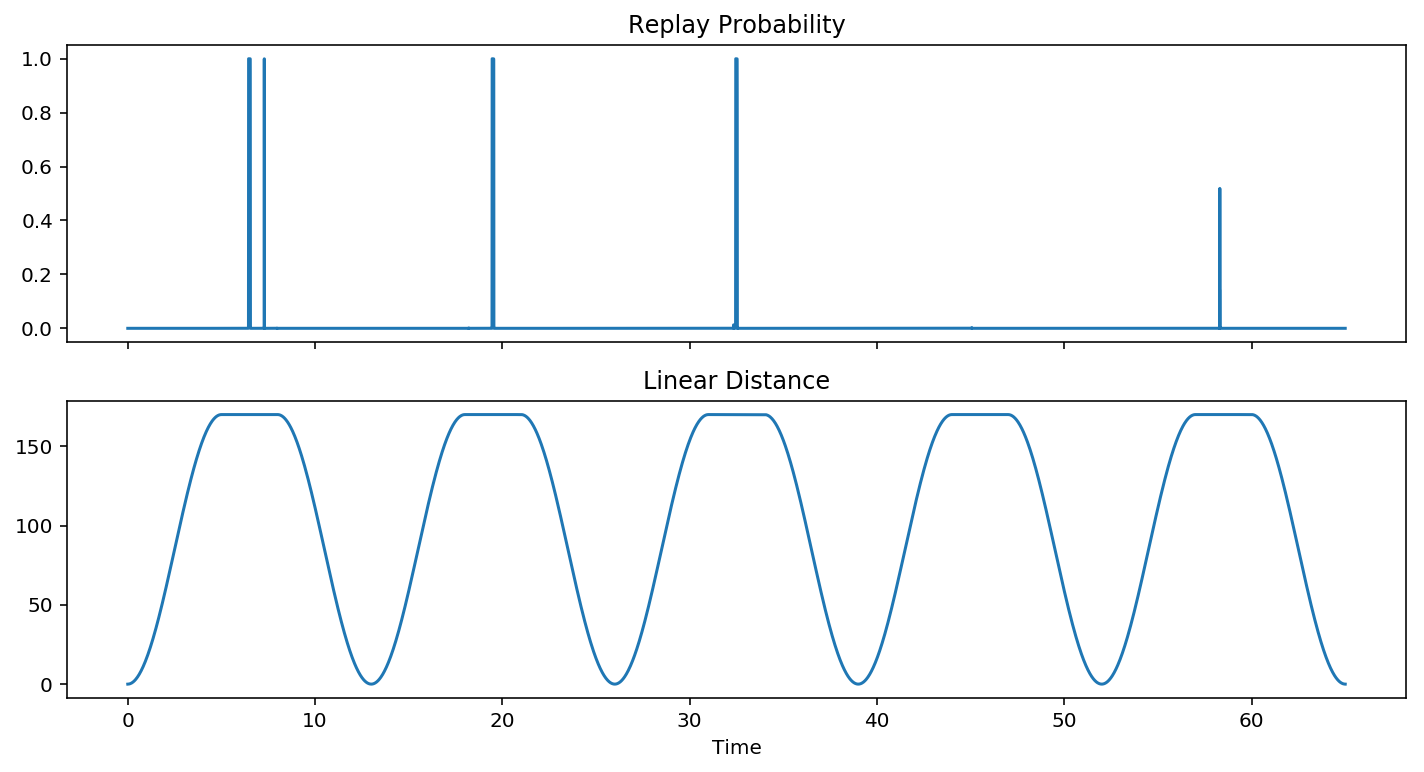

In [73]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

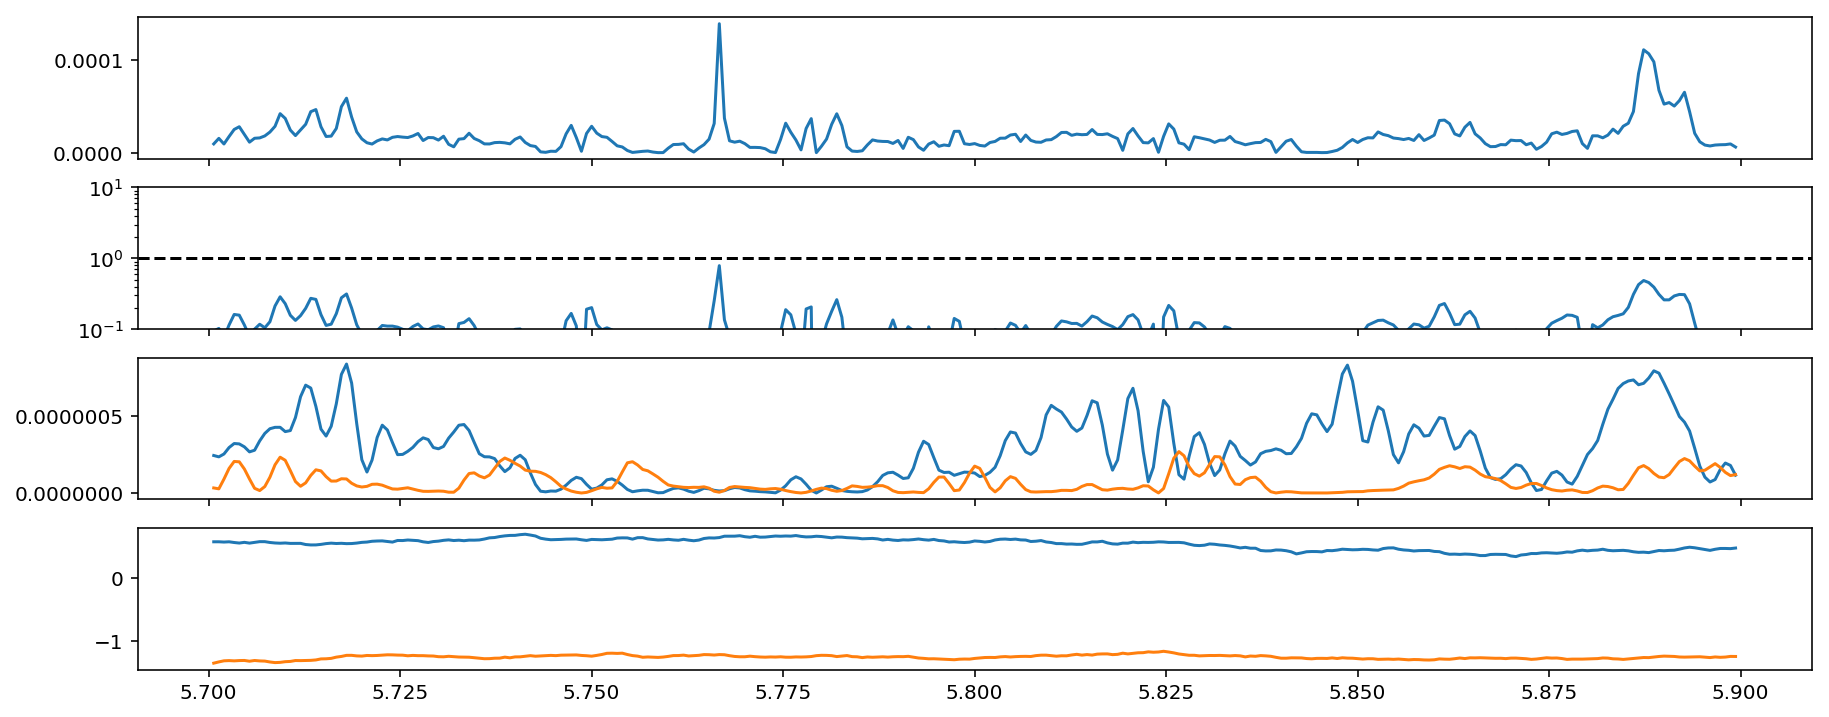

In [27]:
ind = (time > 5.7) & (time < 5.9)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 6))
axes[0].plot(results.time[ind], results.replay_probability[ind])
axes[1].semilogy(results.time[ind], results.likelihood[ind])
axes[1].set_ylim((1E-1, 1E1))
axes[1].axhline(1, color='black', linestyle='--')
axes[2].plot(time[ind], power[ind])
axes[3].plot(time[ind], lfps[ind])

# plt.xlim((5.7, 5.8))
# plt.xlim((0, 10))

### Speed Only

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


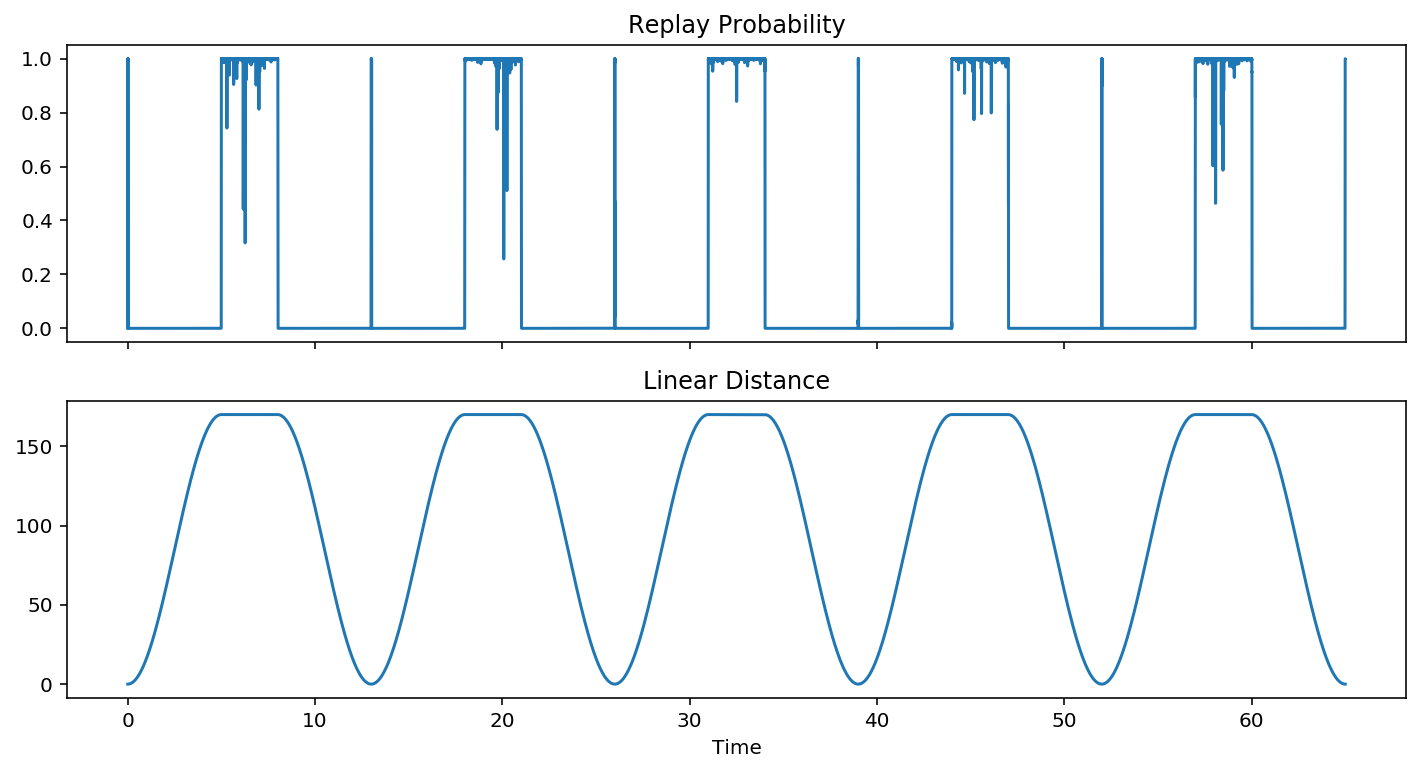

In [74]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['speed'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Speed and Spikes

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


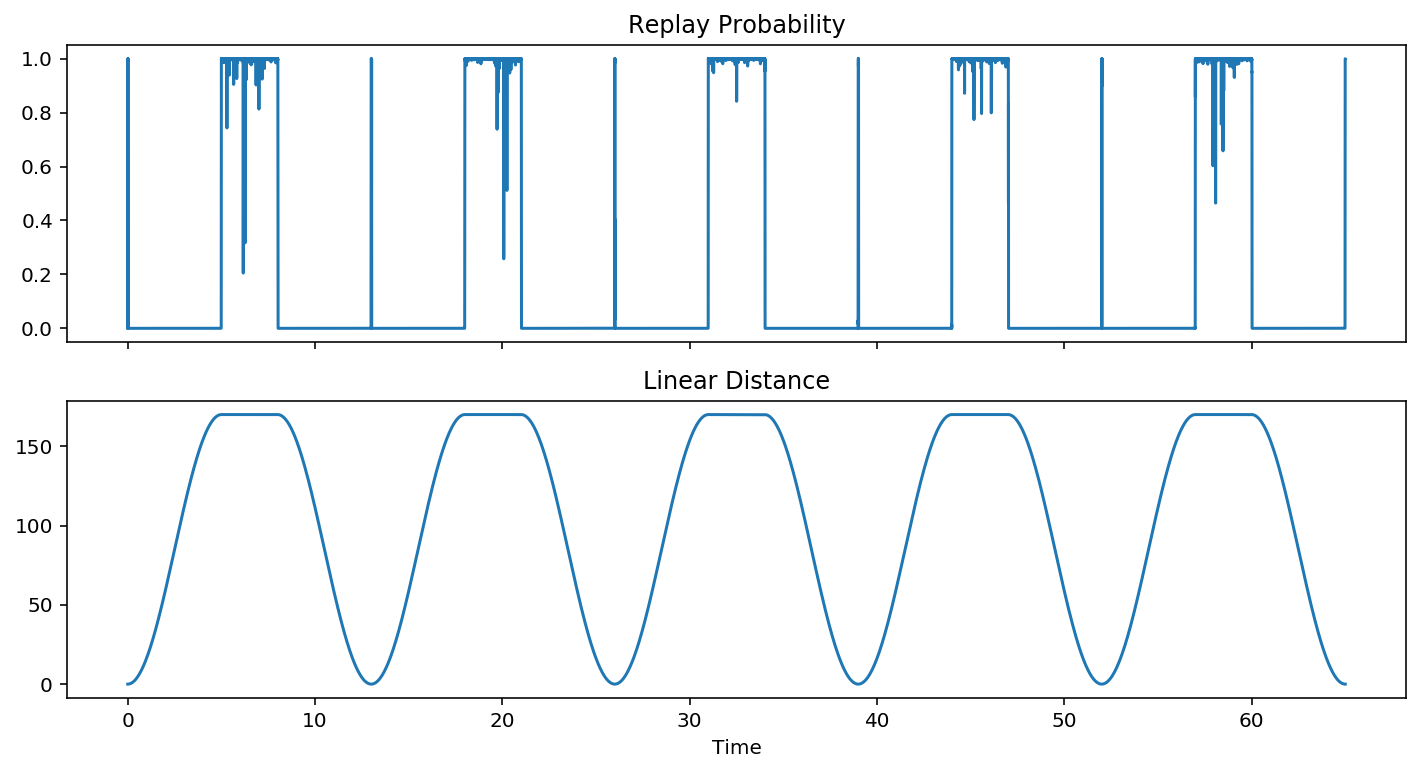

In [75]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['speed', 'spikes'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Spikes and LFP

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


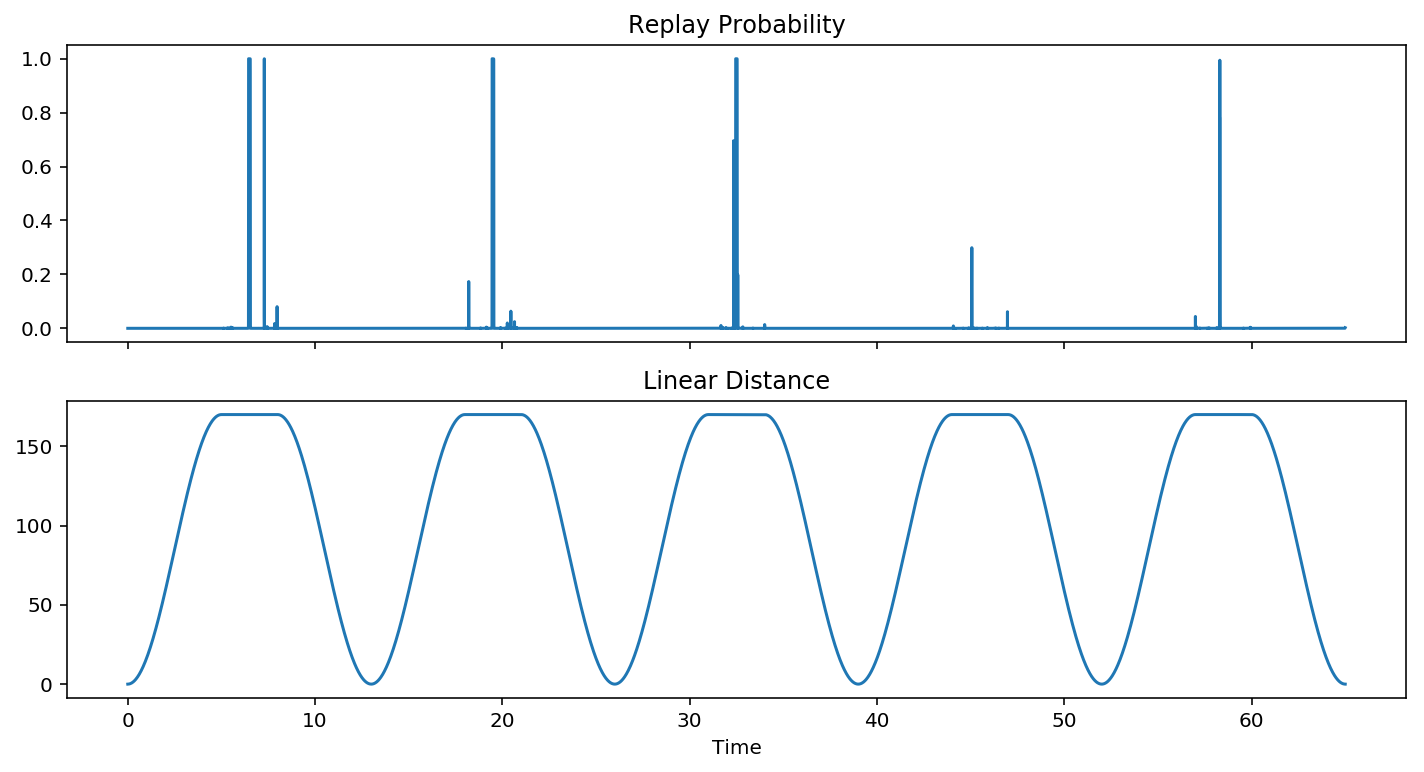

In [30]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['spikes', 'lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Speed and LFP

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


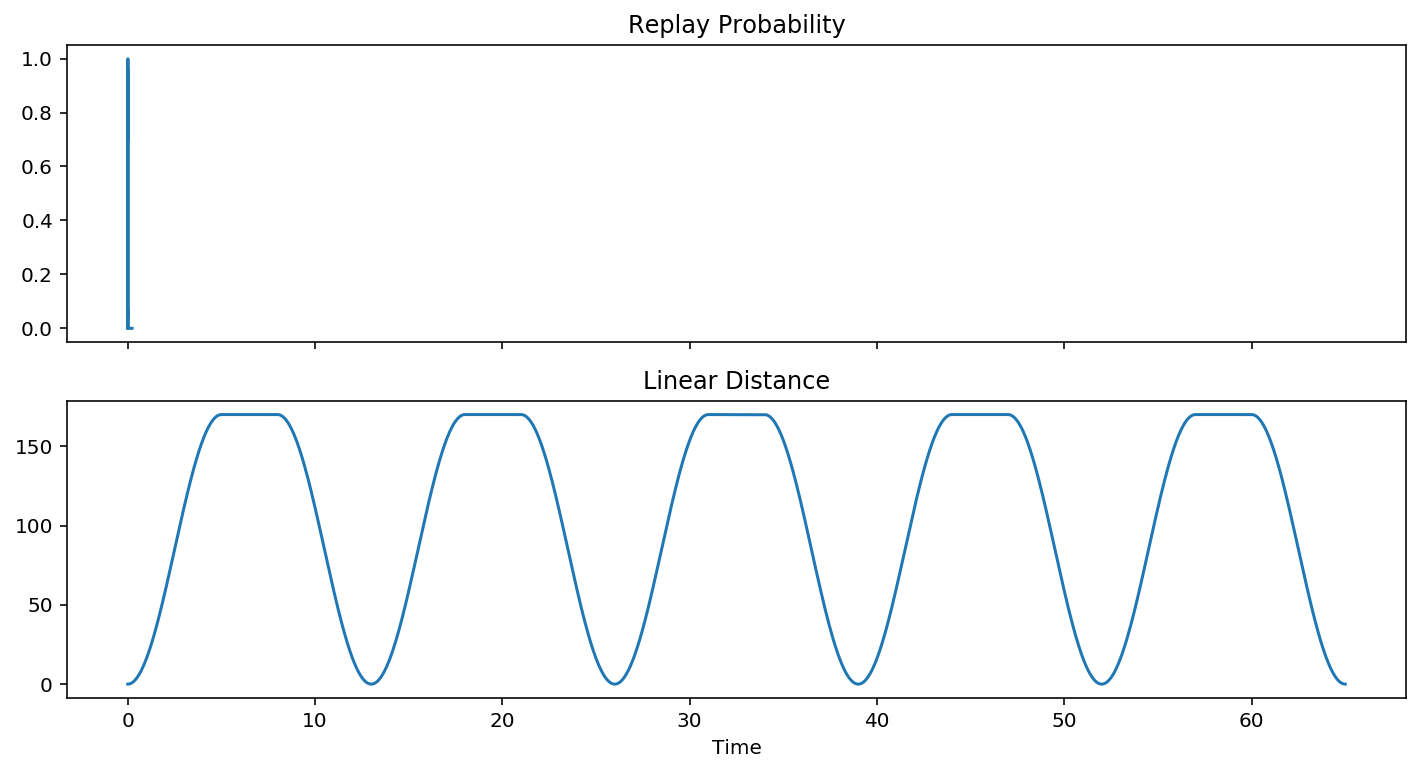

In [31]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['speed', 'lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

## Multiunit Only

INFO:replay_identification.decoders:Predicting multiunit likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


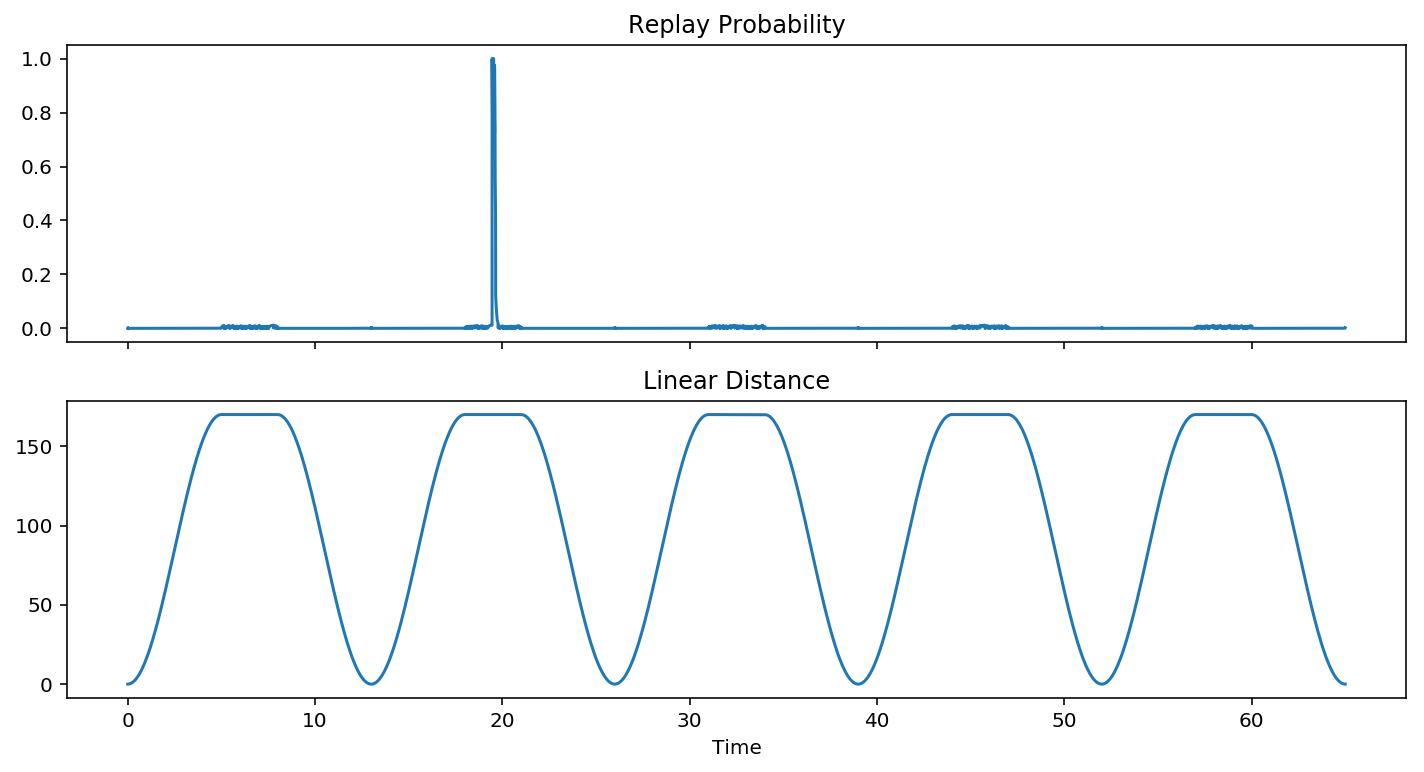

In [32]:
results = r.predict(
    speed, linear_distance, power, spikes, multiunit,
    time=time, use_likelihoods=['multiunit'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


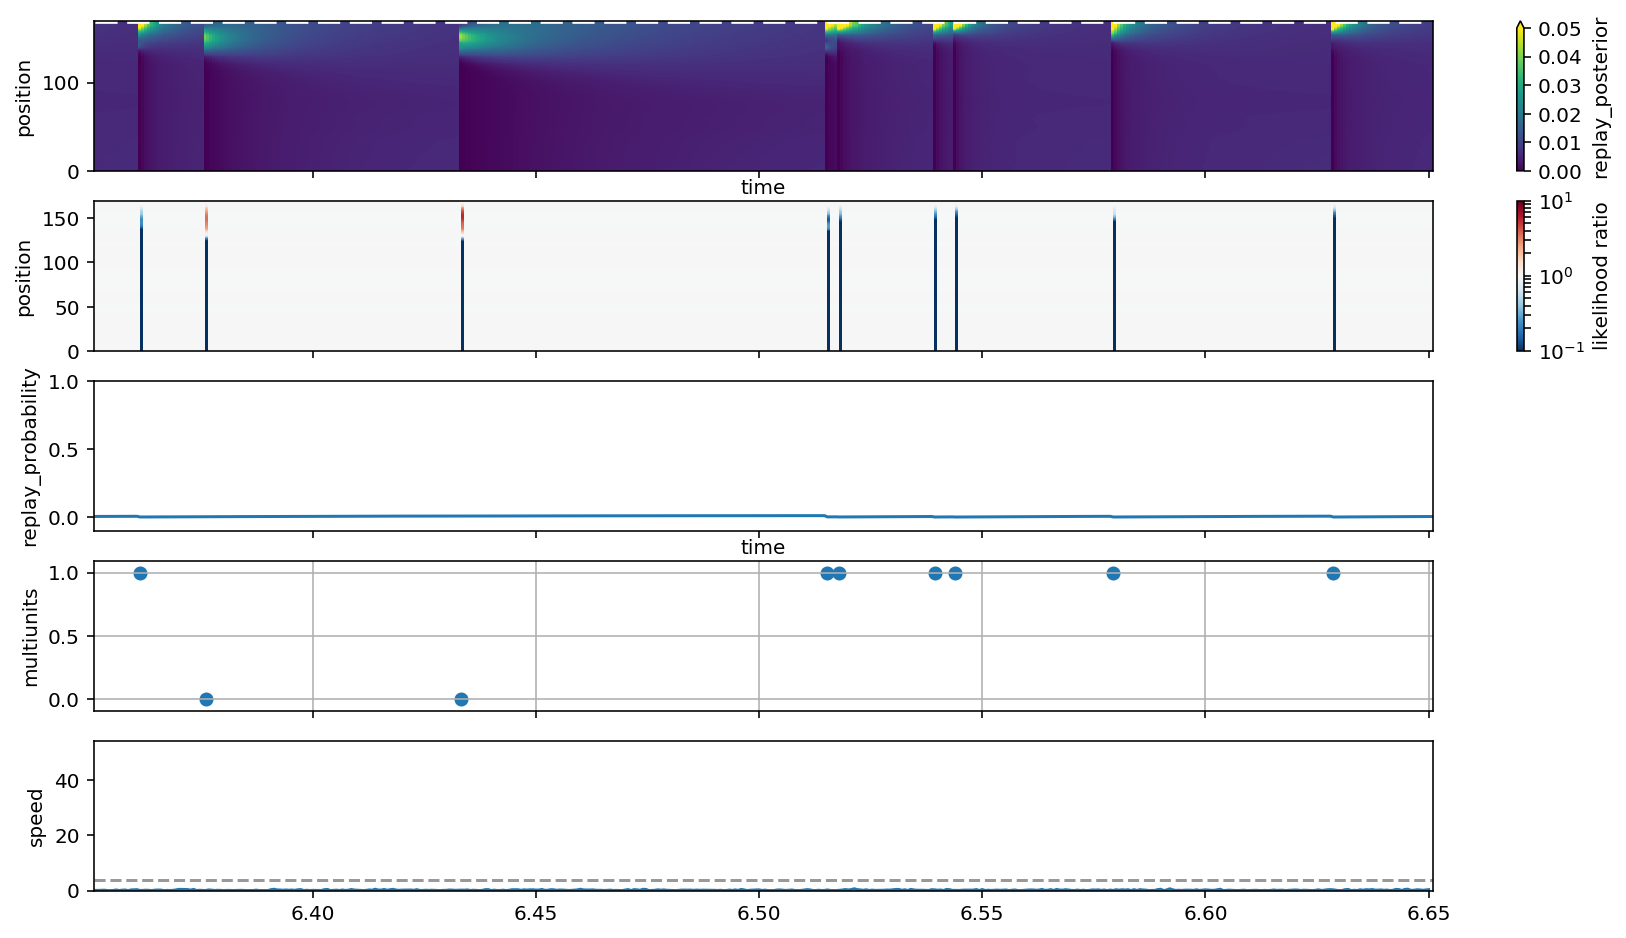

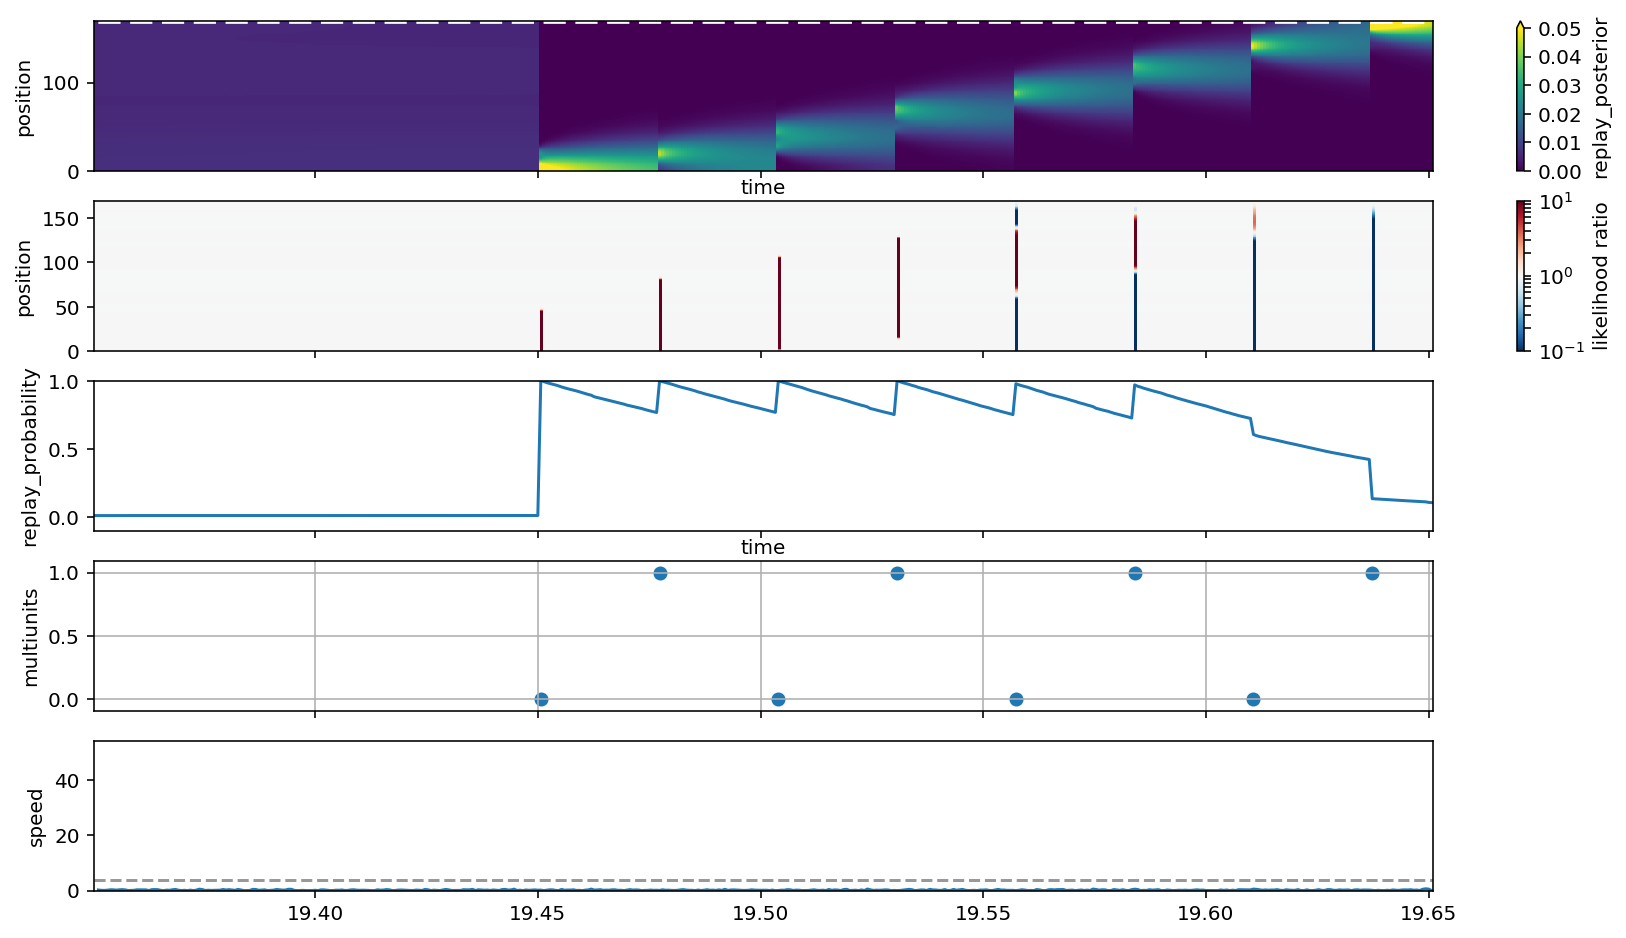

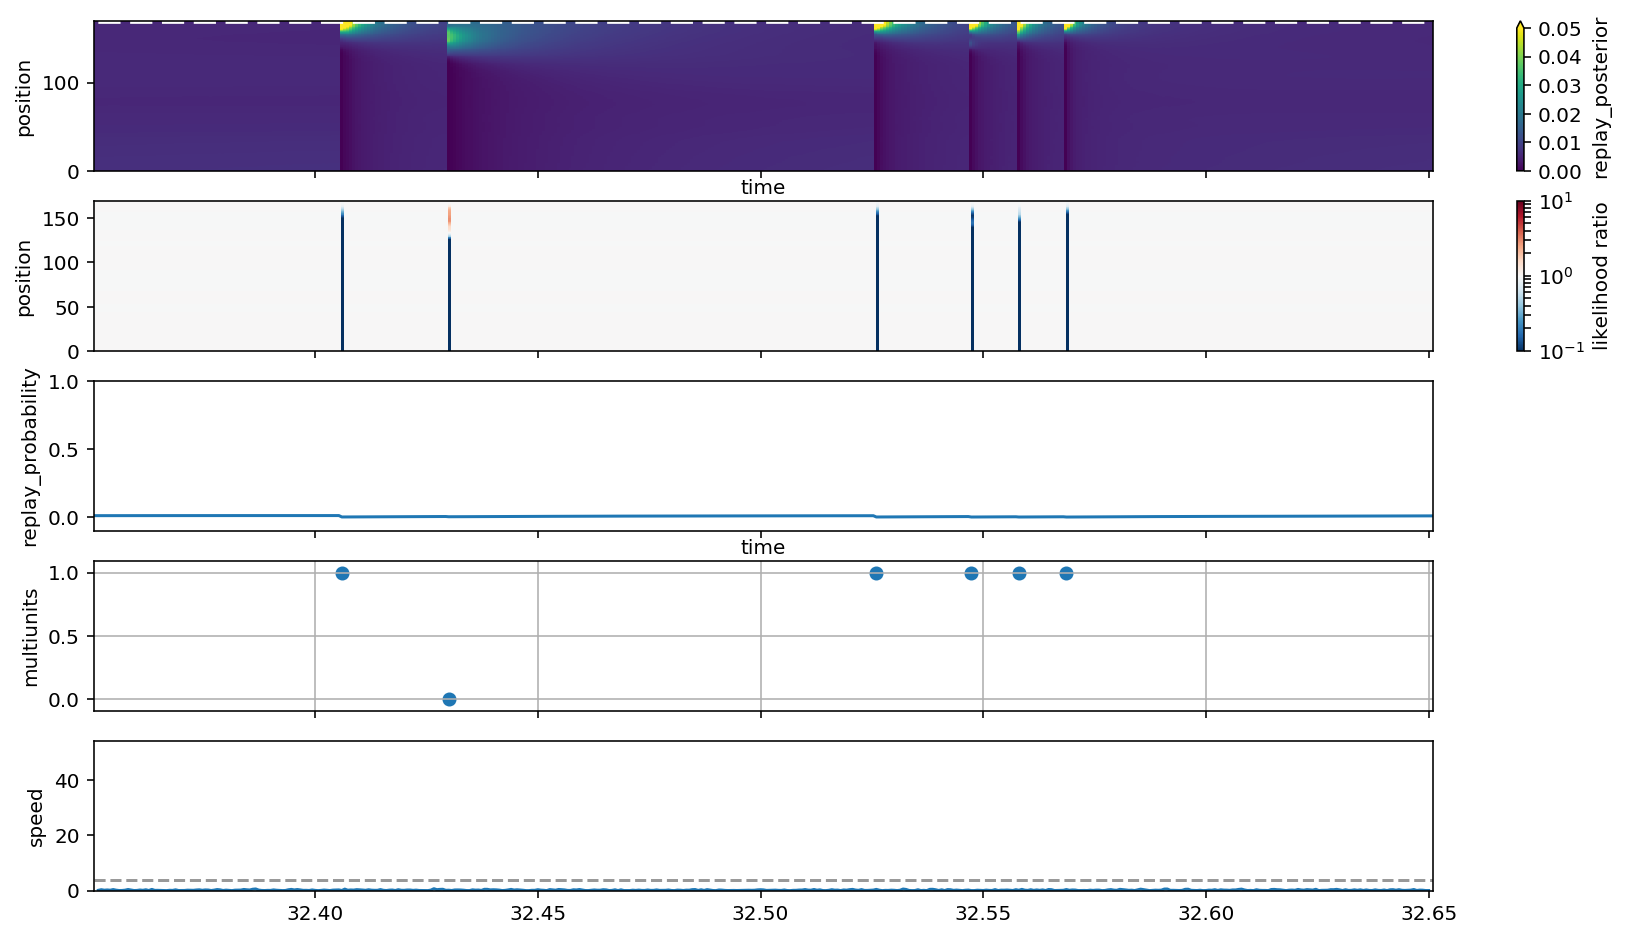

In [33]:
import matplotlib.colors as colors

spike_ind, neuron_ind = np.nonzero(spikes)
vmin, vmax = 0.1, 10

for ripple_ind, (min_time, max_time) in enumerate(ripple_times):
    min_time -= 0.1
    max_time += 0.1
    ind = (time > min_time) & (time < max_time)

    multiunit_spikes = np.any(~np.isnan(multiunit), axis=1) * 1.0

    fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
    results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
            x='time', y='position', ax=axes[0], vmin=0, vmax=0.05)
    axes[0].plot(time[ind], linear_distance[ind],
                 color='white', linestyle='--', linewidth=3)

    likelihood = results.likelihood.sel(time=slice(min_time, max_time))
    t, p = likelihood.time, likelihood.position
    t, p = np.meshgrid(t, p)
    cax = axes[1].pcolormesh(
        t, p, likelihood.values.T,
        norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
    axes[1].set_ylabel('position')
    plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

    sm = plt.cm.ScalarMappable()
    sm.set_array([])

    results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
    axes[2].set_ylim((-0.1, 1))
    plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
    plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
    plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

    time_ind, neuron_ind = np.nonzero(multiunit_spikes[ind])
    axes[3].scatter(time[ind][time_ind], neuron_ind)
    axes[3].grid('on')
    axes[3].set_ylabel('multiunits')

    axes[4].plot(time[ind], speed[ind])
    axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
    axes[4].set_ylim((0, np.nanmax(speed)))
    axes[4].set_ylabel('speed');

## LIkelihoods

In [34]:
lfp_likelihood_ratio = r._lfp_likelihood_ratio(power)

In [35]:
from statsmodels.tsa.tsatools import lagmat

lagged_speed = lagmat(speed, 1)
speed_likelihood_ratio = r._speed_likelihood_ratio(speed, lagged_speed)

In [36]:
spiking_likelihood_ratio = r._spiking_likelihood_ratio(spikes, linear_distance)

(0.0, 64.99933333333334)

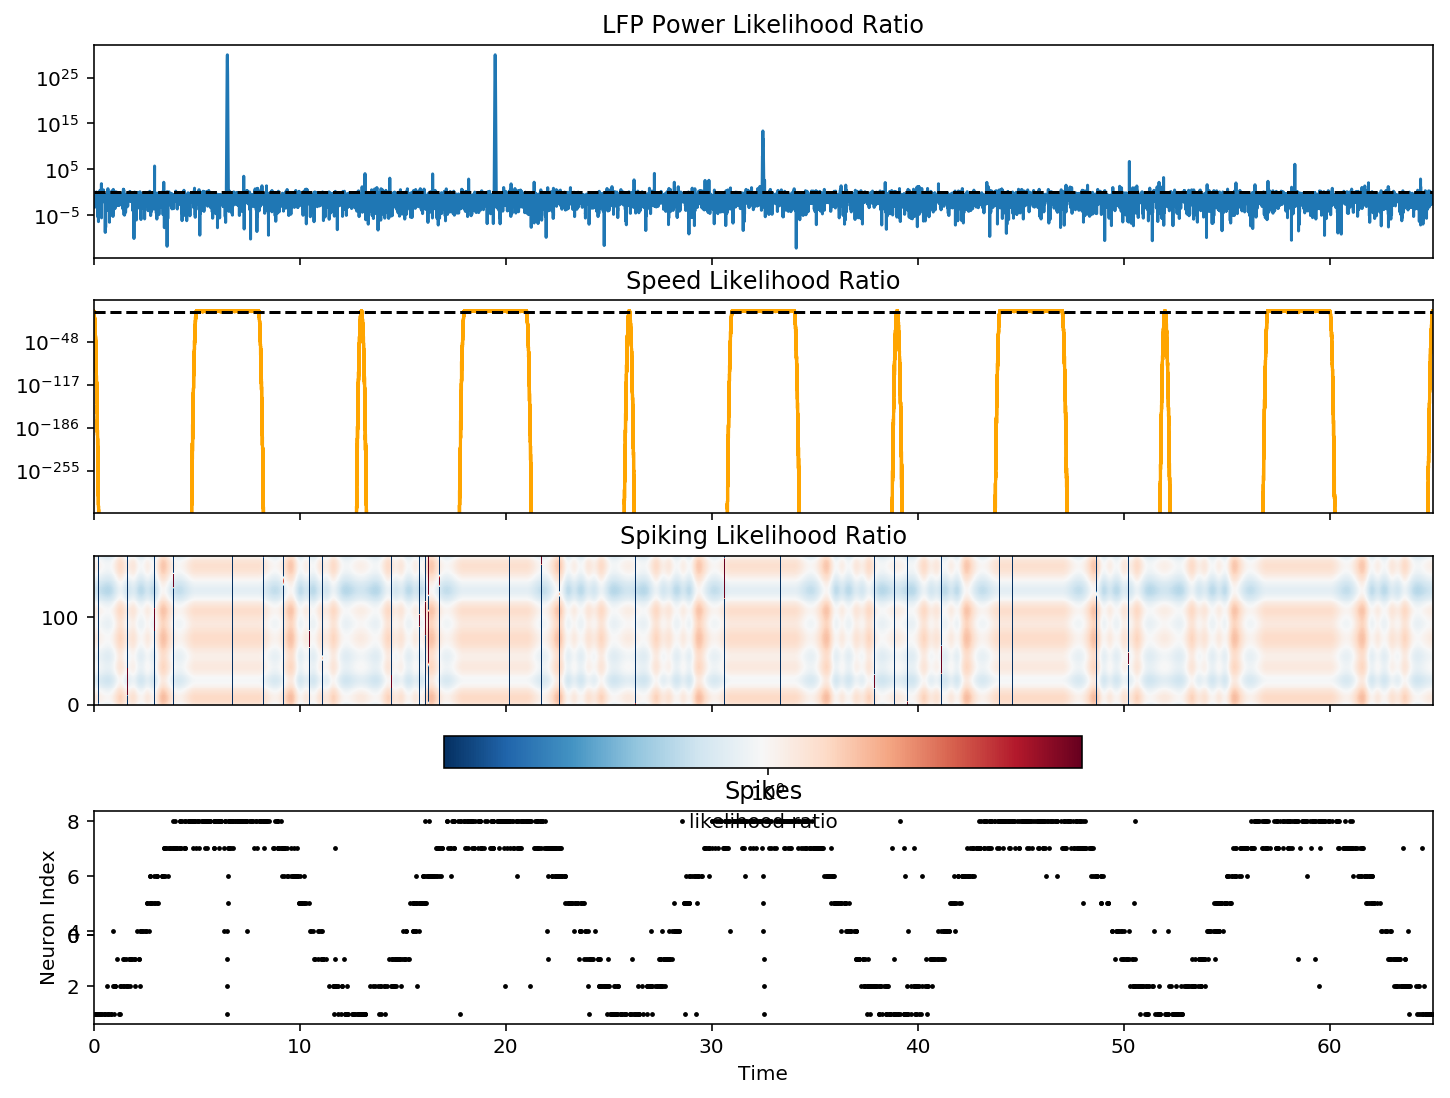

In [37]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 9))

axes[0].semilogy(time, lfp_likelihood_ratio);
axes[0].axhline(1, linestyle='--', color='black')
axes[0].set_title('LFP Power Likelihood Ratio')
axes[1].semilogy(time, speed_likelihood_ratio, color='orange');
axes[1].axhline(1, linestyle='--', color='black')
axes[1].set_title('Speed Likelihood Ratio')

t, p = np.meshgrid(time, r.place_bin_edges)
cax = axes[2].pcolormesh(
    t, p, spiking_likelihood_ratio.T,
    norm=colors.LogNorm(0.97, 1.03), cmap='RdBu_r')
axes[2].set_title('Spiking Likelihood Ratio')
plt.colorbar(cax, ax=axes[2], label='likelihood ratio', orientation='horizontal')

spike_ind, neuron_ind = np.nonzero(spikes)

axes[3].set_title('Spikes')
axes[3].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[3].set_ylabel('Neuron Index')
axes[3].set_xlabel('Time');

plt.xlim((time.min(), time.max()))

# plt.tight_layout()